In [1]:
from importlib import reload

import sys
import os
import numpy as np
import xarray as xr

from copy import deepcopy

from scipy.ndimage import gaussian_filter

from matplotlib import pylab as plt
import cmocean
import json
import cartopy.crs as ccrs

# local modules contain software code that implement the SIC algorithm
from sirrdp import rrdp_file
from pmr_sic import tiepoints as tp
from pmr_sic import algo as sic_algo
from pmr_sic import hybrid_algo
from pmr_sic import common

# prototype re-gridding toolbox to handle the L1B input
if '/Tools/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../..') + '/Tools/')
from tools import io_handler as io
from tools import collocation as coll
from tools import l2_format as l2

# top-level configuration for all plots
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})

In [2]:
# This cell has a tag 'parameters' and is used for the CLI with papermill
#   check python path run_CIMR_L2_Sea_Ice_Concentration_algorithm.py

l1b_path = '../data/input/SCEPS_l1b_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_tot_v2p1.nc'
aux_dir = '../data/aux/'
l2_dir = '../data/output/'

l2_grid = 'ease2-1.0km-testcard'
use_oza_adjust = True
tuning_method = 'CIMRL1B-ALLFEEDS'

In [3]:
# check the input parameters
l1b_scenes = ('devalgo_geometric', 'devalgo_radiometric', 'sceps_polar1')
if not os.path.isfile(l1b_path):
    if l1b_path not in l1b_scenes:
        raise ValueError("The input L1B file does not exist, and is not one of the pre-registred {}".format(l1b_scenes,))

if not os.path.isdir(l2_dir):
    raise ValueError("The output directory {} does not exist.".format(l2_dir))

l2_grids = ('ease2-2.5km-arctic', 'ease2-1.0km-testcard')
if l2_grid not in l2_grids:
    raise ValueError("The provided l2_grid parameter ({}) is not recognized.".format(l2_grid))

if not os.path.isdir(aux_dir):
    raise ValueError("The auxiliary directory {} does not exist.".format(aux_dir))
    
if use_oza_adjust not in (False, True):
    raise ValueError("Parameter use_oza_adjust should be a bool (True or False)")

tuning_methods = ('CCI-RRDP', 'CIMRL1B-ALLFEEDS', 'CIMRL1B-PERFEED')
if tuning_method not in tuning_methods:
    raise ValueError("Algorithm tuning methods must be one of ({})".format(tuning_methods))

In [4]:
# Handle pre-defined L1B files
if l1b_path in l1b_scenes:
    # the CLI gave a pre-defined string to the test scene (geometric, radiometr, sceps polar 1, etc...)
    test_card_name = l1b_path
    if l1b_path == 'devalgo_geometric':    
        # DEVALGO's simulated geometric test card
        l1b_path = '/home/thomasl/Documents/DEVALGO/Simul_L1B_20230421/'
        l1b_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
    elif l1b_path == 'devalgo_radiometric':
        # DEVALGO's simulated radiometric test card
        l1b_path = '/home/thomasl/Documents/DEVALGO/Simul_L1B_20230421/'
        l1b_fn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'
    elif l1b_path == 'sceps_polar1':
        # SCEP's simulated radiometric test card
        l1b_path = '/home/thomasl/Documents/DEVALGO/From_SCEPS_Aug2023/'
        l1b_fn = 'Ref_scen_L1B_TDS/SCEPS/SCEPS_L1B_SCEPS_Geo_Polar_Scene_1/SCEPS_l1b_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_v2p0.nc'
    else:
        raise ValueError("Unknown test_card {}".format(l1b_path))
        
    l1b_path = os.path.join(l1b_path, l1b_fn)
else:
    if 'devalgo_test_scene_1' in os.path.basename(l1b_path):
        test_card_name = 'devalgo_radiometric'
    elif 'devalgo_test_scene_2' in os.path.basename(l1b_path):
        test_card_name = 'devalgo_geometric'
    elif 'sceps_geo_polar_scene_1':
        test_card_name = 'sceps_polar1'
    else:
        test_card_name = 'unknown'
        

In [5]:
# print 
print("Input L1B file: ", l1b_path)
print("Dir for aux data: ", aux_dir)
print("Ouput L2 dir: ", l2_dir)
print("Target L2 grid: ", l2_grid)
print("Use OZA adjusted TBs: ", use_oza_adjust)
print("Algorithm tuning method: ", tuning_method)

Input L1B file:  ../data/input/SCEPS_l1b_sceps_geo_polar_scene_1_unfiltered_tot_minimal_nom_nedt_apc_tot_v2p1.nc
Dir for aux data:  ../data/aux/
Ouput L2 dir:  ../data/output/
Target L2 grid:  ease2-1.0km-testcard
Use OZA adjusted TBs:  True
Algorithm tuning method:  CIMRL1B-ALLFEEDS


In [6]:
algo_version = '0.9.1'

rrdp_dir = './sirrdp'
area = 'nh'
algos = dict()
algos['CKA'] = {'channels':('tb06v', 'tb37v', 'tb37h'), 'target_band':'C'}
algos['KKA'] = {'channels':('tb19v', 'tb37v', 'tb37h'), 'target_band':'KU'}
algos['KA'] = {'channels':('tb37v', 'tb37h'),  'target_band':'KA'}
proj = 'nh'

In [7]:

for alg in algos.keys():
    if tuning_method == 'CIMRL1B-PERFEED':
        algos[alg]['algo'] = []
        # load 1 tuned SIC algo per FEED (target band)
        for f in range(io.n_horns[algos[alg]['target_band']]):
            json_fn = os.path.join(aux_dir,'{}_sic_{}.json'.format(alg.upper(), 'CIMRL1B-FEED{}'.format(f)))
            print("Load tuned {} algo from {}".format(alg, json_fn))
            if not os.path.exists(json_fn):
                raise ValueError("Cannot find AUX parameter file for {} SIC:\n\t{}".format(alg, json_fn))
            with open(json_fn) as fp:
                algo_sic_params = json.load(fp)
            algo_sic_params = common.numpify(algo_sic_params)
            algos[alg]['algo'].append(hybrid_algo.HybridSICAlgo.from_dict(algo_sic_params))
    else:
        # load 1 tune SIC algo
        json_fn = os.path.join(aux_dir,'{}_sic_{}.json'.format(alg.upper(), tuning_method))
        print("Load tuned {} algo from {}".format(alg, json_fn))
        if not os.path.exists(json_fn):
            raise ValueError("Cannot find AUX parameter file for {} SIC:\n\t{}".format(alg, json_fn))
    
        with open(json_fn) as fp:
            algo_sic_params = json.load(fp)
                                    
        algo_sic_params = common.numpify(algo_sic_params)
        algos[alg]['algo'] = hybrid_algo.HybridSICAlgo.from_dict(algo_sic_params)


Load tuned CKA algo from ../data/aux/CKA_sic_CIMRL1B-ALLFEEDS.json
Load tuned KKA algo from ../data/aux/KKA_sic_CIMRL1B-ALLFEEDS.json
Load tuned KA algo from ../data/aux/KA_sic_CIMRL1B-ALLFEEDS.json


In [8]:
# global definitions
tb_dict = {'tb01':'L','tb06':'C','tb10':'X','tb19':'KU','tb37':'KA',}
rev_tb_dict = {v:k for k,v in tb_dict.items()}
bands_needed = []
for alg in algos.keys():
    bands_needed += algos[alg]['channels']
bands_needed = list(set([tb_dict[b[:-1]] for b in bands_needed]))

In [9]:
reload(io)
# read L1B. We only read the bands needed for the three algorithms
full_l1b = io.CIMR_L1B(l1b_path, selected_bands=bands_needed, keep_calibration_view=True,)

# if asked by the user, apply the (pre-computed) OZA adjustment fields for all bands
if use_oza_adjust:
    full_l1b.apply_OZA_adjustment()

# align scanlines using the scan angle offset
full_l1b.align_arrays_to_start_at_zero_scan_angle()

# coarsen l1b samples along the scanlines with a kernel of 5 (horns are *not* combined)
ker = 5
coarsen_l1b = full_l1b.coarsen_along_scanlines(kernel=ker)

# split into forward / backward scan
fwd_l1b, bck_l1b = coarsen_l1b.split_forward_backward_scans(method='horn_scan_angle')

# Collocate the channels with a nearest neighbour approach. This step covers both the
#   definition of the target grid, and the remapping. Use the correct 'target_band' for
#   each algorithm.
#
# The collocation strategy differs for the algos:
#    * CKA -> NN resampling to C
#    * KKA -> along_arc
fwd_l1x = dict()
bck_l1x = dict()
for alg in algos.keys():
    if alg == 'KKA' or alg == 'KA':
        # along arc resampling.
        _fwd_l1x = coll.collocate_channels_alongarc(fwd_l1b.data, algos[alg]['target_band'], )
        _bck_l1x = coll.collocate_channels_alongarc(bck_l1b.data, algos[alg]['target_band'], )
        # reshape by interleaving the feeds 
        fwd_l1x[alg] = coll.reshape_l1x_byinterleave(_fwd_l1x, view='forward')
        bck_l1x[alg] = coll.reshape_l1x_byinterleave(_bck_l1x, view='backward')
    else:
        # CKA: first transform 3D arrays (scan, sample, feed) into 2D (scan_interleave_feed, sample), then
        #    NN resampling.
        reshaped_fwd_l1b = fwd_l1b.reshape_interleave_feed()
        reshaped_bck_l1b = bck_l1b.reshape_interleave_feed()
        fwd_l1x[alg] = coll.collocate_channels(reshaped_fwd_l1b.data, algos[alg]['target_band'], method='nn')
        bck_l1x[alg] = coll.collocate_channels(reshaped_bck_l1b.data, algos[alg]['target_band'], method='nn')

# prepare TBs in the structure expected as input to the algorithm
fwd_tbs = dict()
bck_tbs = dict()
for alg in algos.keys():
    fwd_tbs[alg] = dict()
    bck_tbs[alg] = dict()
    for ch in algos[alg]['channels']:
        band = tb_dict[ch[:-1]] + '_BAND'
        varn = 'brightness_temperature_'+ch[-1]
        fwd_tbs[alg][ch] = fwd_l1x[alg][band][varn].values
        bck_tbs[alg][ch] = bck_l1x[alg][band][varn].values
            
# extract the lat/lon arrays for later use in the pan-sharpening
fwd_geo = dict()
bck_geo = dict()
for alg in algos.keys():
    fwd_geo[alg] = dict()
    bck_geo[alg] = dict()
    for ll in ('lat','lon',):
        fwd_geo[alg][ll] = fwd_l1x[alg]['geolocation'][ll].to_numpy()
        bck_geo[alg][ll] = bck_l1x[alg]['geolocation'][ll].to_numpy()
        
# extract the orig_horn arrays (for the target band)
fwd_feed = dict()
bck_feed = dict()
for alg in algos.keys():
    fwd_feed[alg] = fwd_l1x[alg][algos[alg]['target_band']+'_BAND'].orig_horn.to_numpy()
    bck_feed[alg] = bck_l1x[alg][algos[alg]['target_band']+'_BAND'].orig_horn.to_numpy()
    

WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for KA:scan_angle_feeds_offsets_relative_to_reflector


WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for KA:apc_hv_hbs
WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for KA:apc_hv_ext


WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for KU:scan_angle_feeds_offsets_relative_to_reflector


WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for KU:apc_hv_hbs
WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for KU:apc_hv_ext


WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for C:scan_angle_feeds_offsets_relative_to_reflector
WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for C:apc_hv_hbs
WARNING (align_arrays_to_start_at_zero_scan_angle): dim n_horns is not in 3rd pos for C:apc_hv_ext


/home/thomasl/Work/DEVALGO/Tools/tools/collocation.py:145: RuntimeWarning: invalid value encountered in cast
  coll_dict[w] = coll_dict[w].astype(dtypes[w])


/home/thomasl/Work/DEVALGO/Tools/tools/collocation.py:236: RuntimeWarning: invalid value encountered in cast
  coll_dict[w] = coll_dict[w].astype(l1b_data[band][w].dtype)


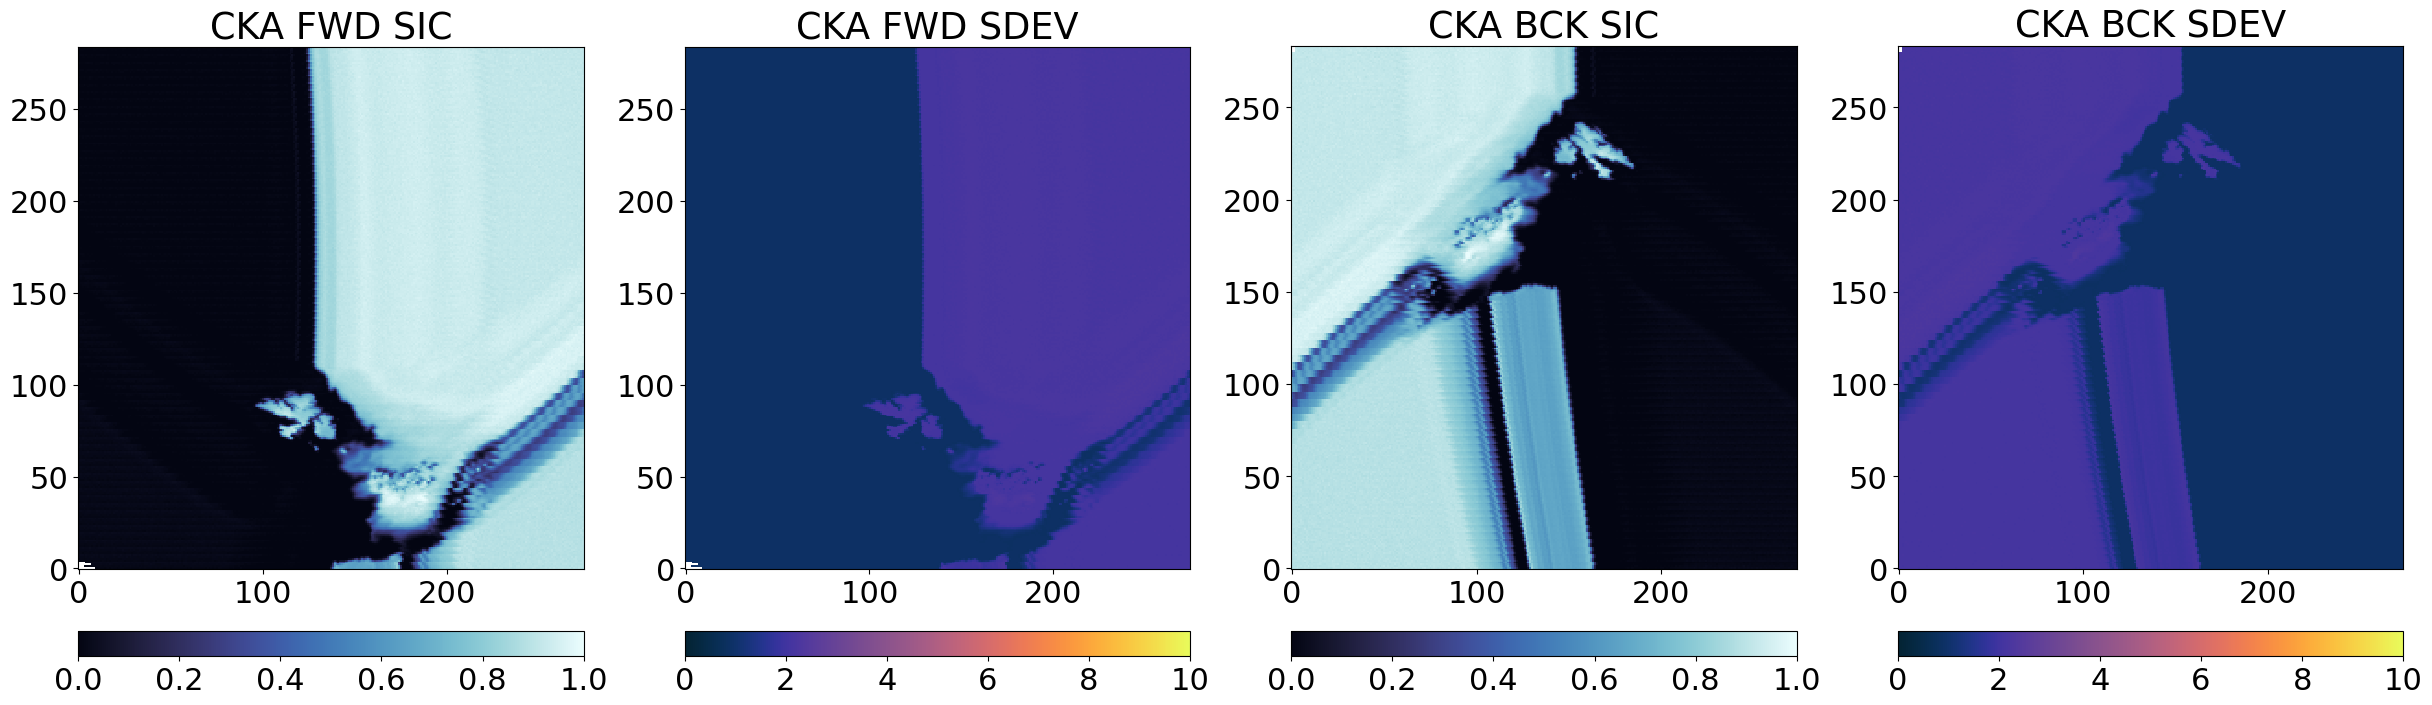

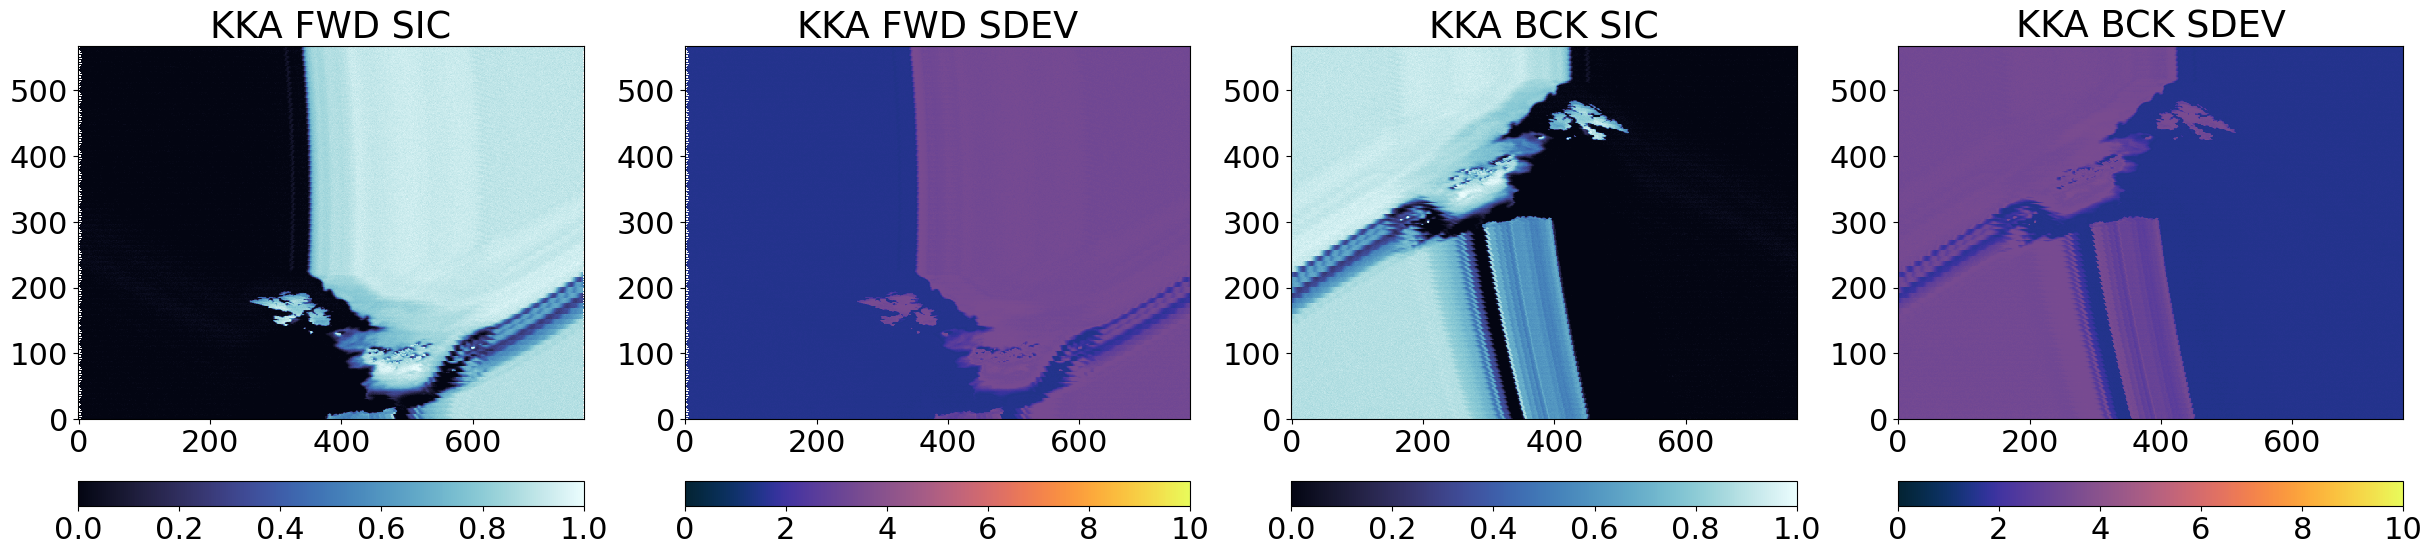

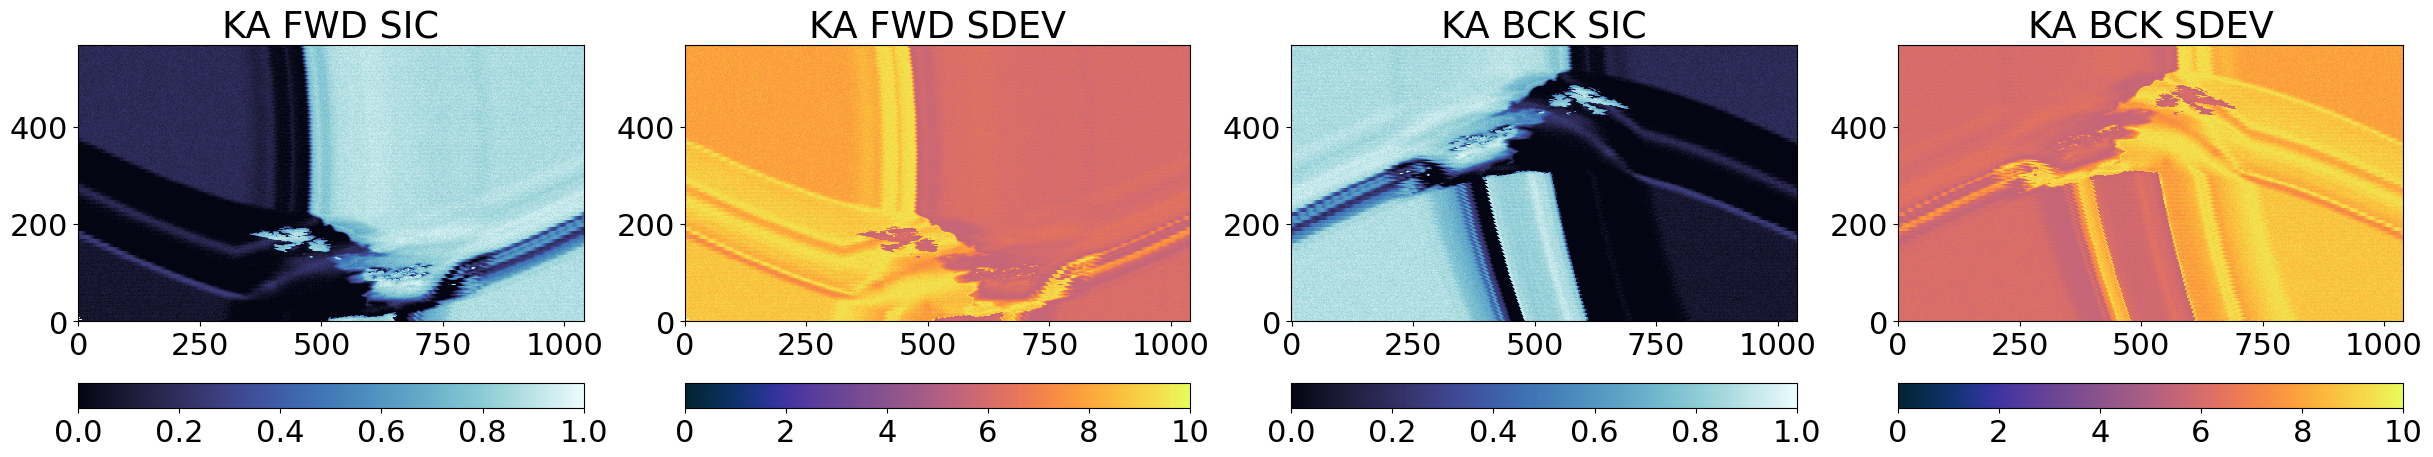

In [10]:
fwd_res = dict()
bck_res = dict()
for alg in algos.keys():
    
    # run the algorithm to compute SIC
    if tuning_method == 'CIMRL1B-PERFEED':
        # Run Nfeed algorithms, each on its feed scanlines, then reconstruct the 2D field
        
        # prepare the 2D result fields (filled with nans)
        _ch0 = algos[alg]['channels'][0]
        _fwd_sic = np.ones_like(fwd_tbs[alg][_ch0]) * np.nan
        _fwd_sdev = np.ones_like(fwd_tbs[alg][_ch0]) * np.nan
        _fwd_dal = np.ones_like(fwd_tbs[alg][_ch0]) * np.nan
        _fwd_owf = np.ones_like(fwd_tbs[alg][_ch0]).astype('int16') * -1
        _bck_sic = np.ones_like(bck_tbs[alg][_ch0]) * np.nan
        _bck_sdev = np.ones_like(bck_tbs[alg][_ch0]) * np.nan
        _bck_dal = np.ones_like(bck_tbs[alg][_ch0]) * np.nan
        _bck_owf = np.ones_like(bck_tbs[alg][_ch0]).astype('int16') * -1
        for f in range(io.n_horns[algos[alg]['target_band']]):
            # prepare TBs with nans everywhere expect for the current feed
            _fwd_tbs = deepcopy(fwd_tbs[alg])
            _bck_tbs = deepcopy(bck_tbs[alg])
            for ch in algos[alg]['channels']:
                _fwd_tbs[ch][fwd_feed[alg]!=f] = np.nan
                _bck_tbs[ch][bck_feed[alg]!=f] = np.nan
            # run the feed-specific algorithm 
            _fwd_sicf, _fwd_sdevf, _fwd_dalf, _fwd_owff = algos[alg]['algo'][f].compute_sic(_fwd_tbs)
            _bck_sicf, _bck_sdevf, _bck_dalf, _bck_owff = algos[alg]['algo'][f].compute_sic(_bck_tbs)
            # place the results into the 2D fields
            _fwd_sic[fwd_feed[alg]==f] = _fwd_sicf[fwd_feed[alg]==f]
            _fwd_sdev[fwd_feed[alg]==f] = _fwd_sdevf[fwd_feed[alg]==f]
            _fwd_dal[fwd_feed[alg]==f] = _fwd_dalf[fwd_feed[alg]==f]
            _fwd_owf[fwd_feed[alg]==f] = _fwd_owff[fwd_feed[alg]==f]
            _bck_sic[bck_feed[alg]==f] = _bck_sicf[bck_feed[alg]==f]
            _bck_sdev[bck_feed[alg]==f] = _bck_sdevf[bck_feed[alg]==f]
            _bck_dal[bck_feed[alg]==f] = _bck_dalf[bck_feed[alg]==f]
            _bck_owf[bck_feed[alg]==f] = _bck_owff[bck_feed[alg]==f]
        # store these results in a SICAlgoResults object
        fwd_res[alg] = sic_algo.SICAlgoResult(_fwd_sic, _fwd_sdev, _fwd_dal, _fwd_owf)
        bck_res[alg] = sic_algo.SICAlgoResult(_bck_sic, _bck_sdev, _bck_dal, _bck_owf)
        
    else:
        # Run the algorithm on the 2D fields directly
        fwd_res[alg] = algos[alg]['algo'].compute_sic(fwd_tbs[alg])
        bck_res[alg] = algos[alg]['algo'].compute_sic(bck_tbs[alg])
    
    # Simple visualization in swath L1X geometry
    cmap = cmocean.cm.ice
    ucmap = cmocean.cm.thermal
    vmin, vmax = (0, 1)
    umin, umax = (0, 10)
    
    fig = plt.figure(figsize=(30,16))
    axF = fig.add_subplot(1,4,1)
    cF = axF.imshow(fwd_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axF.set_title(alg + " " + "FWD" + " " + "SIC")
    plt.colorbar(cF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,2, sharex=axF, sharey=axF)
    uF = ax.imshow(fwd_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "FWD" + " " + "SDEV")
    plt.colorbar(uF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    axB = fig.add_subplot(1,4,3)
    cB = axB.imshow(bck_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axB.set_title(alg + " " + "BCK" + " " + "SIC")
    plt.colorbar(cB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,4, sharex=axB, sharey=axB)
    uB=ax.imshow(bck_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "BCK" + " " + "SDEV")
    plt.colorbar(uB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])


In [11]:
algo = 'CKA@KA'
base, sharpener = algo.split('@')

In [12]:
reload(coll)
# extract target and source geometries
fwd_trg_lon = fwd_geo[sharpener]['lon']
fwd_trg_lat = fwd_geo[sharpener]['lat']
fwd_src_lon = fwd_geo[base]['lon']
fwd_src_lat = fwd_geo[base]['lat']
bck_trg_lon = bck_geo[sharpener]['lon']
bck_trg_lat = bck_geo[sharpener]['lat']
bck_src_lon = bck_geo[base]['lon']
bck_src_lat = bck_geo[base]['lat']

# Prepare a stack of the data to be regridded (e.g. SIC and SDEV)
what = ('sic','sdev','dal','owf')
fwd_stack_shape = tuple(list(fwd_src_lat.shape) + [len(what),])
bck_stack_shape = tuple(list(bck_src_lat.shape) + [len(what),])
fwd_src_stack = np.empty(fwd_stack_shape)
bck_src_stack = np.empty(bck_stack_shape)
for iw, w in enumerate(what):
    fwd_src_stack[...,iw] = fwd_res[base].get(w)
    bck_src_stack[...,iw] = bck_res[base].get(w)

# regrid and get _bAs (base @ sharpener grid), 
_fwd_bAs = coll._regrid_fields(fwd_trg_lon, fwd_trg_lat, fwd_src_lon, fwd_src_lat, fwd_src_stack)
_bck_bAs = coll._regrid_fields(bck_trg_lon, bck_trg_lat, bck_src_lon, bck_src_lat, bck_src_stack)

# store in an object
fwd_res[algo + '(bAs)'] = sic_algo.SICAlgoResult(_fwd_bAs[...,0], _fwd_bAs[...,1], _fwd_bAs[...,2], _fwd_bAs[...,3])
bck_res[algo + '(bAs)'] = sic_algo.SICAlgoResult(_bck_bAs[...,0], _bck_bAs[...,1], _bck_bAs[...,2], _bck_bAs[...,3])

In [13]:
# The bAs now has the same shape as the sharpener
assert(fwd_res[sharpener].sic.shape == fwd_res[algo+'(bAs)'].sic.shape)
assert(bck_res[sharpener].sic.shape == bck_res[algo+'(bAs)'].sic.shape)

In [14]:
reload(coll)

# extract target and source geometries (the same: we stay in the sharpener's grid)
fwd_trg_lon = fwd_geo[sharpener]['lon']
fwd_trg_lat = fwd_geo[sharpener]['lat']
fwd_src_lon = fwd_geo[sharpener]['lon']
fwd_src_lat = fwd_geo[sharpener]['lat']
bck_trg_lon = bck_geo[sharpener]['lon']
bck_trg_lat = bck_geo[sharpener]['lat']
bck_src_lon = bck_geo[sharpener]['lon']
bck_src_lat = bck_geo[sharpener]['lat']
# Prepare a stack of the data to be regridded (only the SIC)
what = ('sic',)
fwd_stack_shape = tuple(list(fwd_src_lat.shape) + [len(what),])
bck_stack_shape = tuple(list(bck_src_lat.shape) + [len(what),])
fwd_src_stack = np.empty(fwd_stack_shape)
bck_src_stack = np.empty(bck_stack_shape)
for iw, w in enumerate(what):
    fwd_src_stack[...,iw] = fwd_res[sharpener].get(w)
    bck_src_stack[...,iw] = bck_res[sharpener].get(w)

# regrid and get _sbl (sharpener blurred)
params = {'method':'gauss', 'sigmas':25000, 'neighbours':55}
_fwd_sbl = coll._regrid_fields(fwd_trg_lon, fwd_trg_lat, fwd_src_lon, fwd_src_lat, fwd_src_stack, params=params)
_bck_sbl = coll._regrid_fields(bck_trg_lon, bck_trg_lat, bck_src_lon, bck_src_lat, bck_src_stack, params=params)

# store in an object
fwd_res[algo + '(blur)'] = sic_algo.SICAlgoResult(_fwd_sbl[...,0], fwd_res[sharpener].sdev, fwd_res[sharpener].dal, fwd_res[sharpener].owf)
bck_res[algo + '(blur)'] = sic_algo.SICAlgoResult(_bck_sbl[...,0], bck_res[sharpener].sdev, bck_res[sharpener].dal, bck_res[sharpener].owf)

/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 55 neighbours within 62500.0 m for some data points
  get_neighbour_info(source_geo_def,


In [15]:
# compute the delta edges
_fwd_delta = fwd_res[sharpener].sic - fwd_res[algo + '(blur)'].sic
_bck_delta = bck_res[sharpener].sic - bck_res[algo + '(blur)'].sic

# store in an object (intermediate result, we store it only for visualization in the notebook)
_fwd_zeros = np.zeros_like(_fwd_delta)
_bck_zeros = np.zeros_like(_bck_delta)
fwd_res[algo + '(delta)'] = sic_algo.SICAlgoResult(_fwd_delta, _fwd_zeros, _fwd_zeros, _fwd_zeros)
bck_res[algo + '(delta)'] = sic_algo.SICAlgoResult(_bck_delta, _bck_zeros, _bck_zeros, _bck_zeros)

In [16]:
# compute final pan-sharpened SIC
_fwd_er = fwd_res[algo+'(bAs)'].sic + _fwd_delta
_bck_er = bck_res[algo+'(bAs)'].sic + _bck_delta

# store in an object
_fwd_zeros = np.zeros_like(_fwd_delta)
_bck_zeros = np.zeros_like(_bck_delta)
fwd_res[algo] = sic_algo.SICAlgoResult(_fwd_er, fwd_res[algo+'(bAs)'].sdev, _fwd_zeros, fwd_res[algo+'(bAs)'].owf)
bck_res[algo] = sic_algo.SICAlgoResult(_bck_er, bck_res[algo+'(bAs)'].sdev, _bck_zeros, bck_res[algo+'(bAs)'].owf)

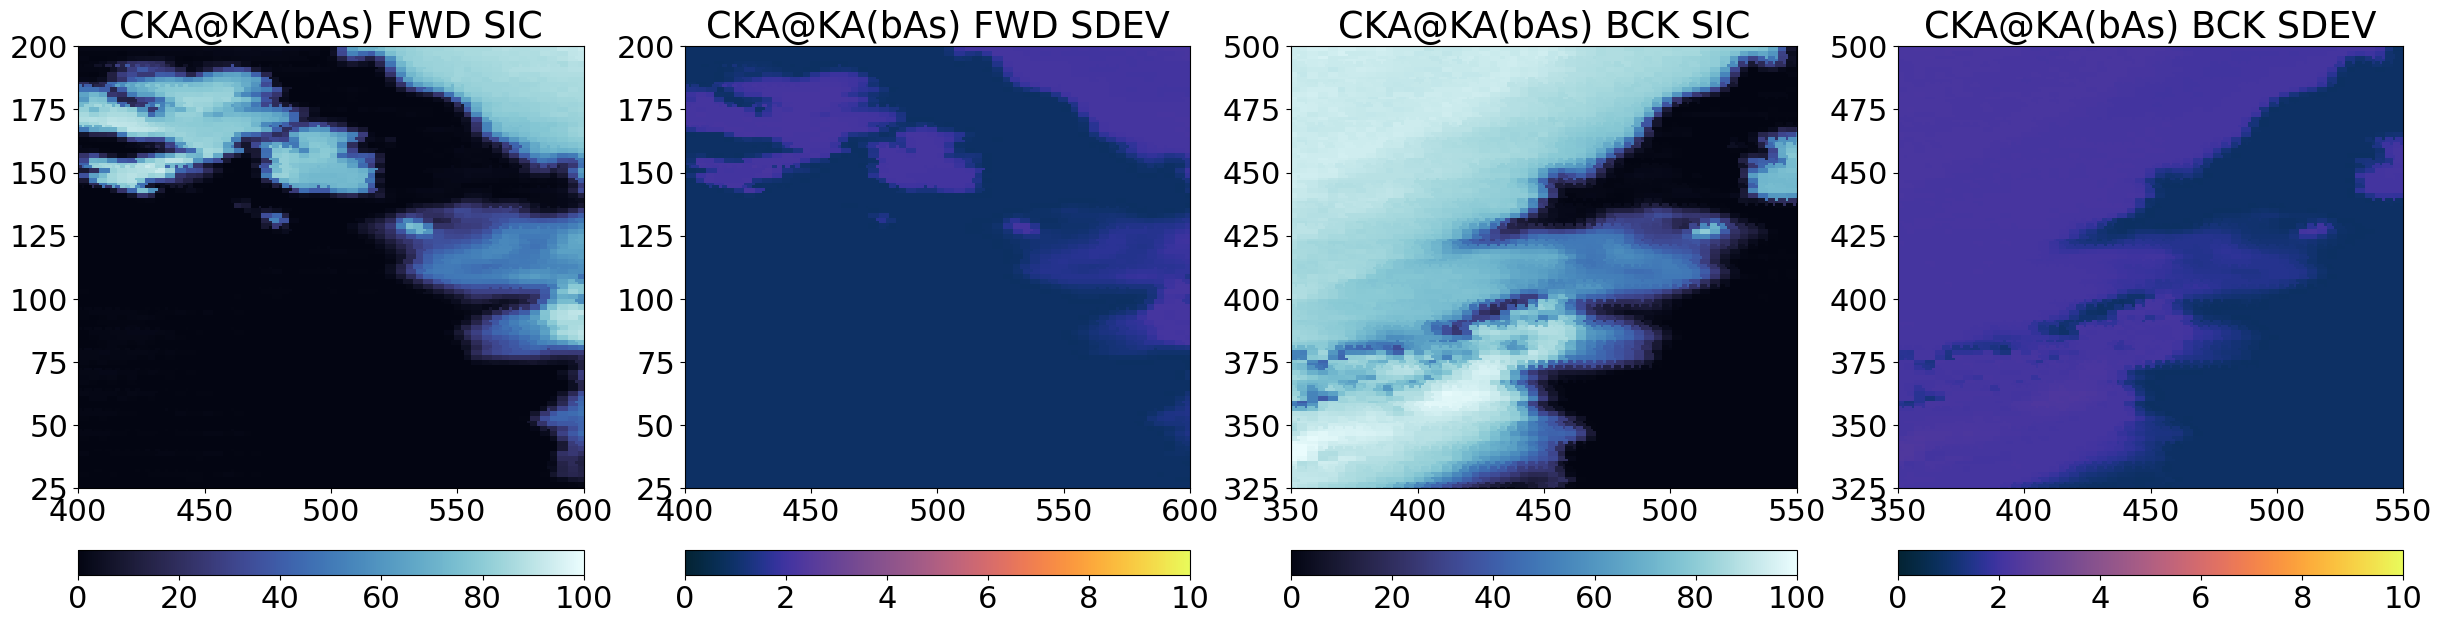

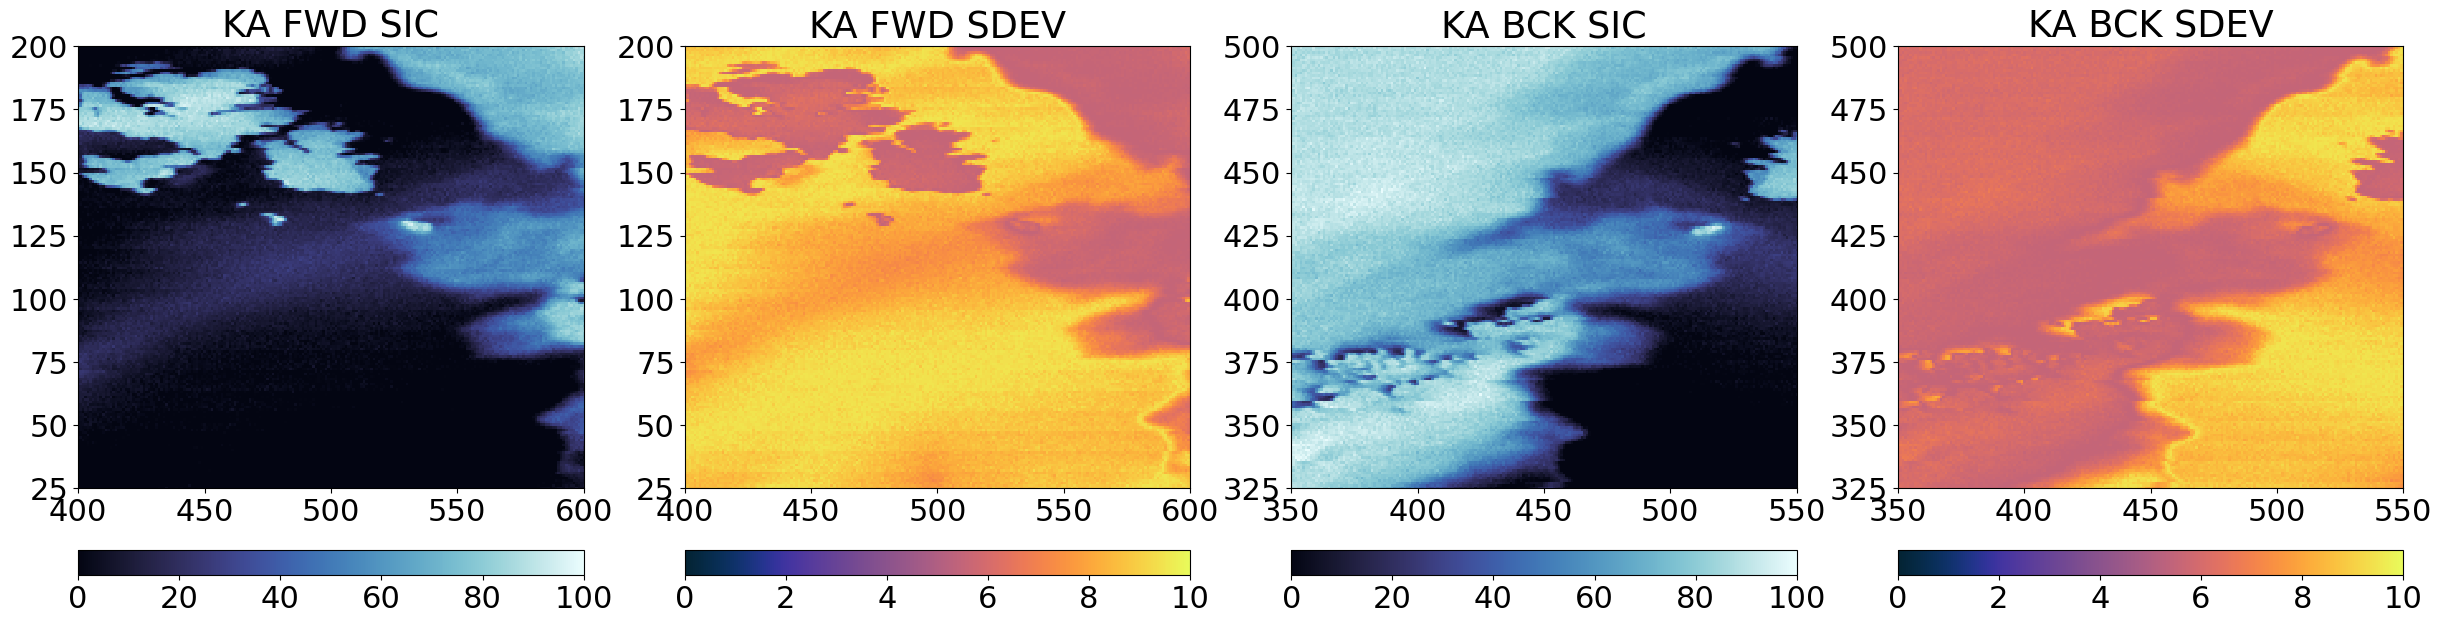

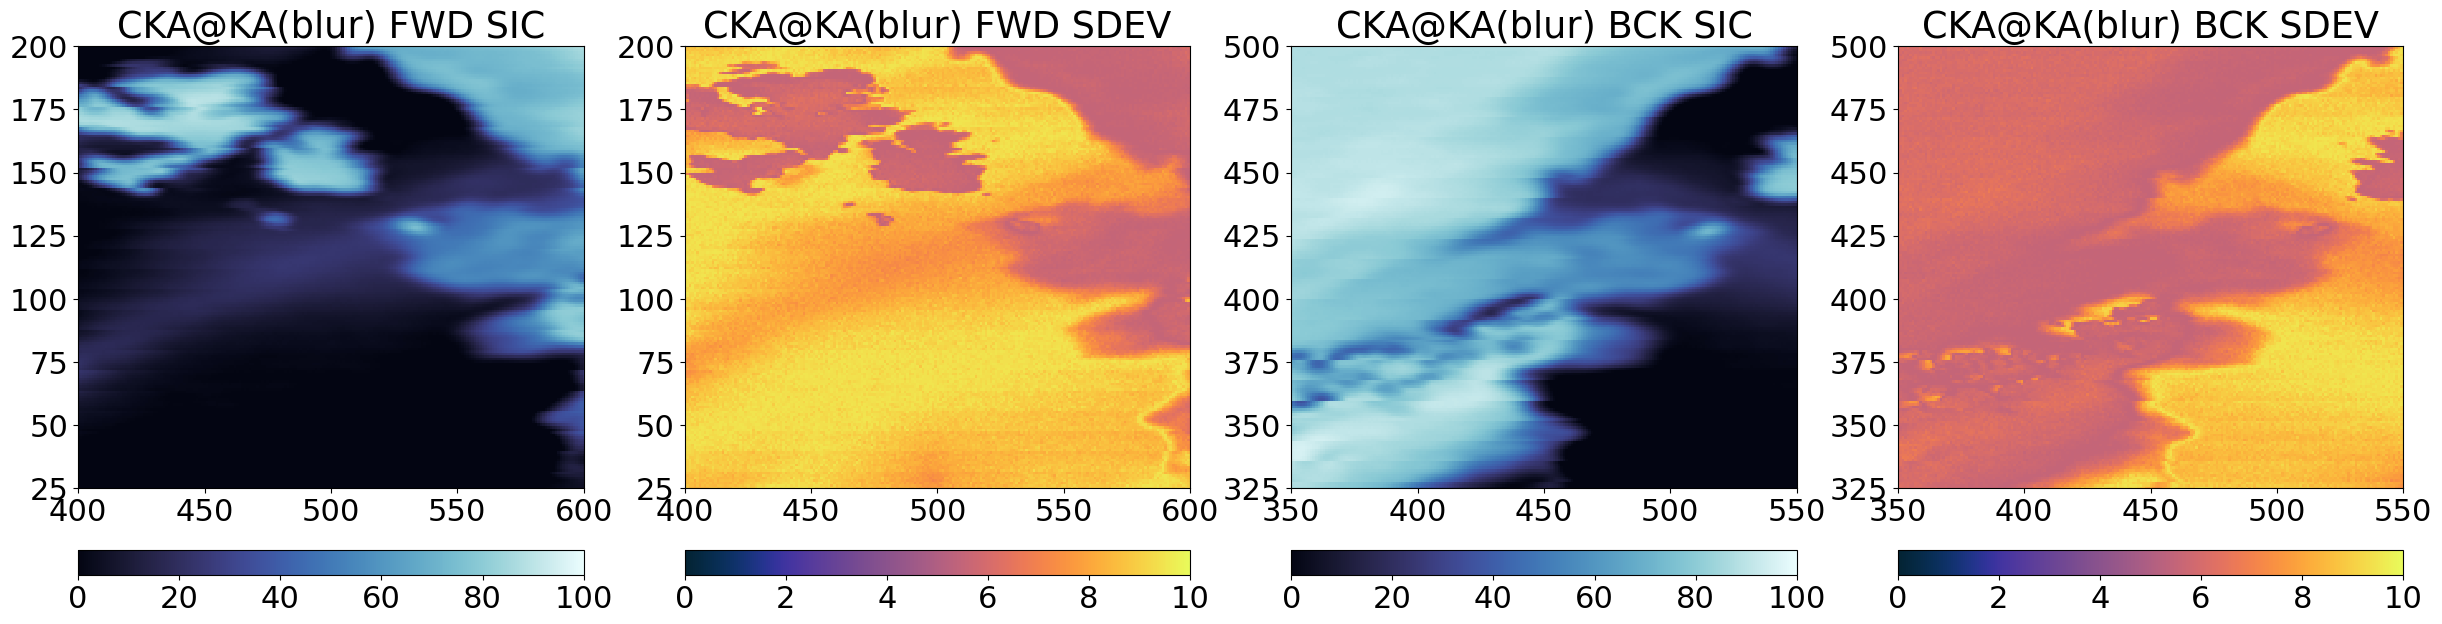

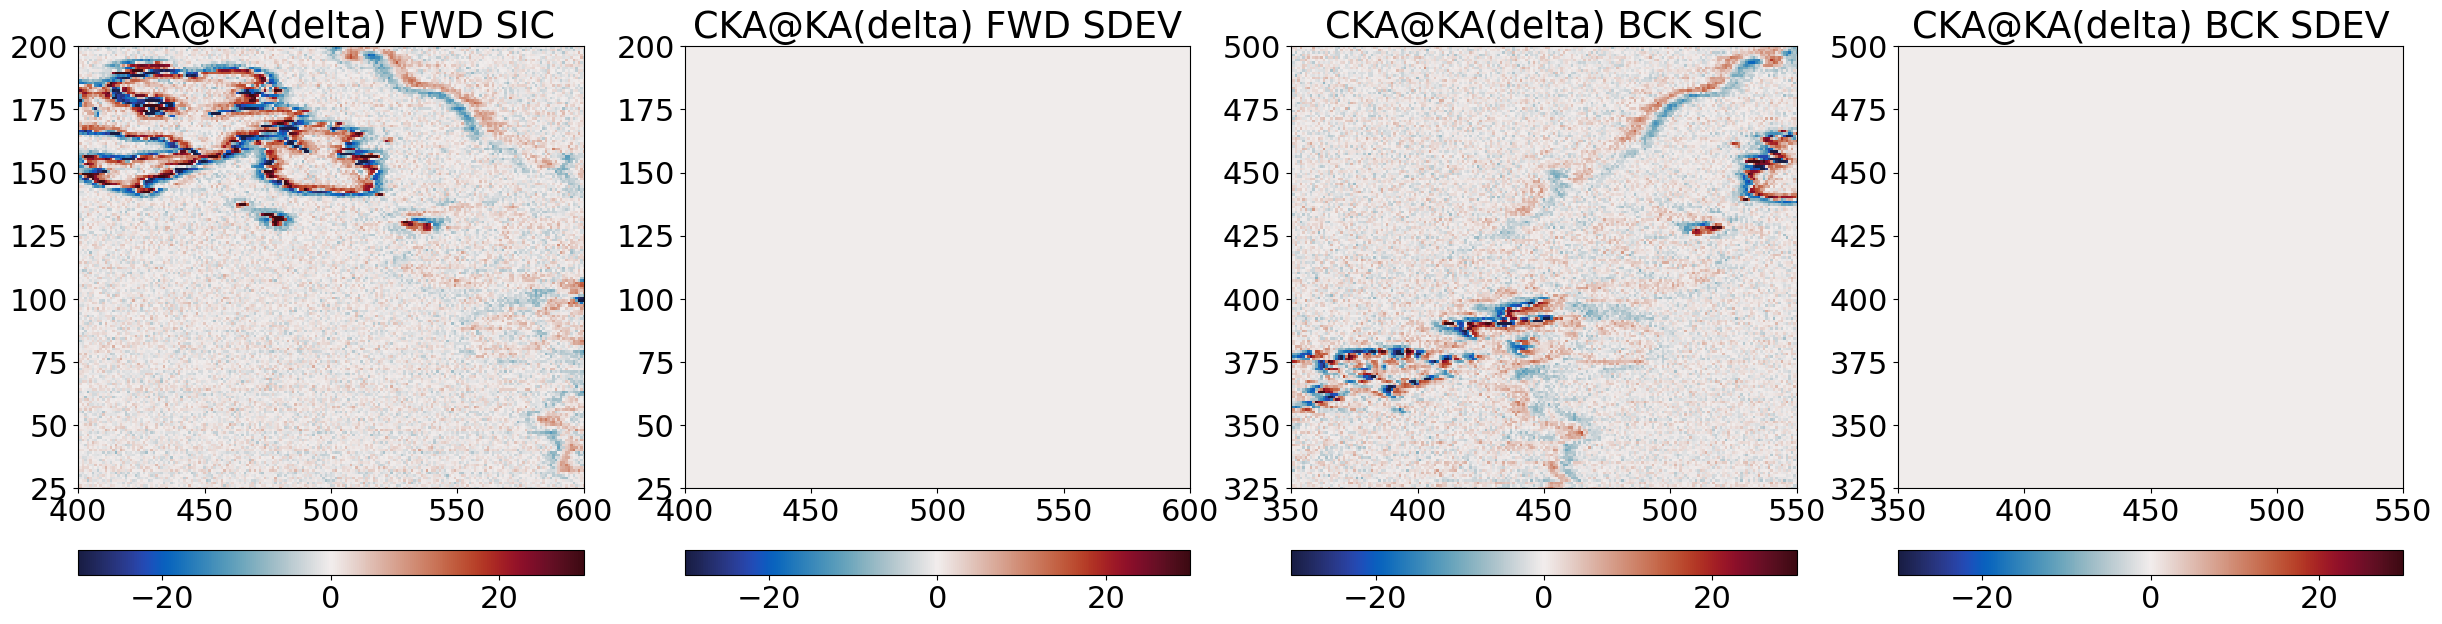

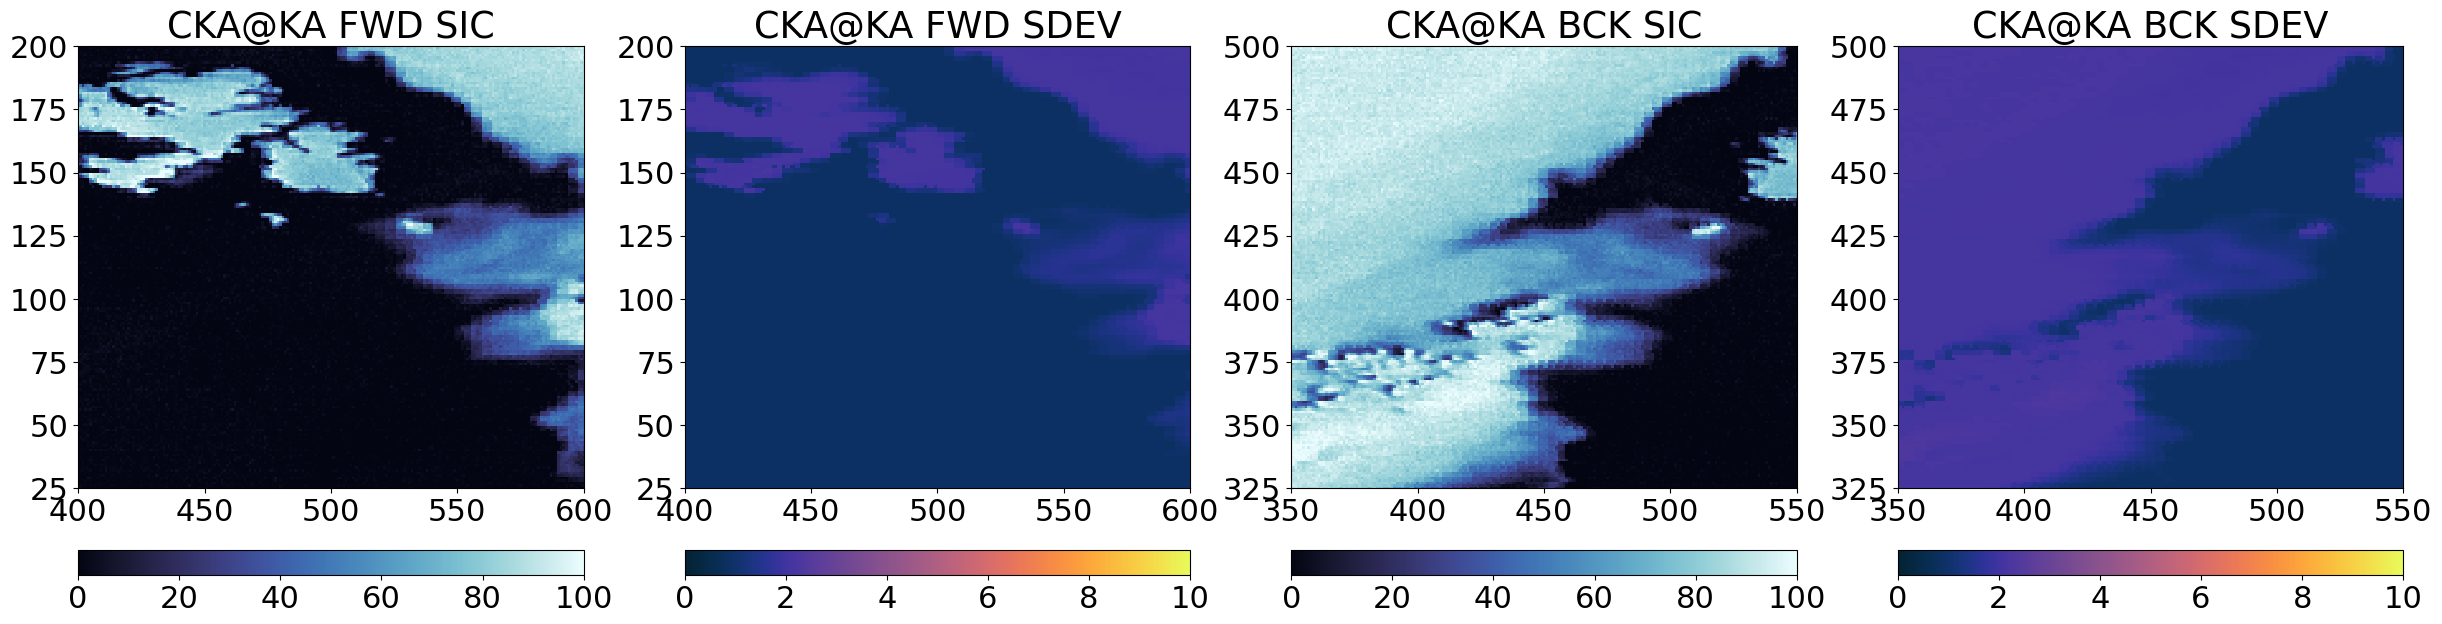

In [17]:
# Simple visualization in swath L1X geometry
for alg in (algo + '(bAs)', sharpener, algo + '(blur)', algo + '(delta)', algo):
    cmap = cmocean.cm.ice
    ucmap = cmocean.cm.thermal
    vmin, vmax = (0, 100)
    umin, umax = (0, 10)
    if 'delta' in alg:
        cmap = cmocean.cm.balance
        ucmap = cmap
        vmin, vmax = (-30, 30)
        umin, umax = (vmin, vmax)
    fig = plt.figure(figsize=(30,16))
    axF = fig.add_subplot(1,4,1)
    cF = axF.imshow(100*fwd_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axF.set_title(alg + " " + "FWD" + " " + "SIC")
    plt.colorbar(cF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,2, sharex=axF, sharey=axF)
    uF = ax.imshow(fwd_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "FWD" + " " + "SDEV")
    plt.colorbar(uF,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    axB = fig.add_subplot(1,4,3)
    cB = axB.imshow(100*bck_res[alg].sic, vmin=vmin, vmax=vmax, interpolation = 'none', origin='lower', cmap=cmap)
    axB.set_title(alg + " " + "BCK" + " " + "SIC")
    plt.colorbar(cB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    ax = fig.add_subplot(1,4,4, sharex=axB, sharey=axB)
    uB=ax.imshow(bck_res[alg].sdev, vmin=umin, vmax=umax, interpolation = 'none', origin='lower', cmap=ucmap)
    ax.set_title(alg + " " + "BCK" + " " + "SDEV")
    plt.colorbar(uB,orientation='horizontal', pad=0.05)
    #ax.set_xticks([]); ax.set_yticks([])
    
    axF.set_xlim(400,600)
    axF.set_ylim(25,200)
    axB.set_xlim(350,550)
    axB.set_ylim(325,500)
    
    plt.show()


In [18]:
import pyresample as pr
from pyresample import parse_area_file

if l2_grid == 'ease2-2.5km-arctic':
    
    grid_def_file = os.path.join('grids_py.def')

    grid_n = 'nh-ease2-025'
    adef  = parse_area_file(grid_def_file, grid_n)[0]
    trg_lon, trg_lat = adef.get_lonlats()
    trg_spacing = 2500

elif l2_grid == 'ease2-1.0km-testcard':
    # load the area definition from a yaml file
    yaml_file = './testcard_adef.yaml'
    adef = pr.load_area(yaml_file, 'crs')
    trg_lon, trg_lat = adef.get_lonlats()
    trg_spacing = 1000
    print(adef)
    
    ##  IF you do not have the yaml file, this is how it can be created
    ## path to the polar testcard netCDF file to load the projection information
    #tc_fn = '/home/thomasl/Downloads/test_scene_1_compressed_lowres.nc'
    #
    #ds = xr.open_dataset(tc_fn)
    #
    #adef_tc, _ = pr.utils.load_cf_area(ds, variable='L_band_H', y='y', x='x')
    #trg_spacing = 1000
    #trg_lon, trg_lat = adef_tc.get_lonlats()
    # 
    #file_lon = ds['Longitude'].data
    #file_lat = ds['Latitude'].data
    #trg_spacing = 1000
    #print('max difference in lon:', abs(file_lon-trg_lon).max())
    #print('min difference in lat:', abs(file_lat-trg_lat).max())
    #
    #print("pyresample AreaDefinition for the TestCard:")
    #print(adef_tc)
    #adef = adef_tc
    #
    #adef.dump(filename=yaml_file)
else:
    raise ValueError("Unknown target grid for the gridding: {}".format(l2_grid))


Area ID: crs
Description: crs
Projection: {'datum': 'WGS84', 'lat_0': '90', 'lon_0': '0', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 1400
Number of rows: 1400
Area extent: (0.0, -100000.0, 1400000.0, -1500000.0)


In [19]:
fwd_grd = dict()
bck_grd = dict()

# SICs to grid
galgs = ('KA', 'KKA', 'CKA', 'CKA@KA')

for galg in galgs:
    print("Grid FWD and BCK fields for {}".format(galg))
    if '@' in galg:
        geo_n = galg.split('@')[1]
    else:
        geo_n = galg

    # this is the mean spacing of the SIC field, which is about 4000m for KA and K
    src_spacing = 4000
    if galg == 'CKA':
        src_spacing = 10000

    # extract source geometries (those of the 'sharpener' field)
    fwd_src_lon = fwd_geo[geo_n]['lon']
    fwd_src_lat = fwd_geo[geo_n]['lat']
    bck_src_lon = bck_geo[geo_n]['lon']
    bck_src_lat = bck_geo[geo_n]['lat']

    # Prepare a stack of the data to be regridded (SIC and sdev)
    what = ('sic','sdev','owf')
    fwd_stack_shape = tuple(list(fwd_src_lat.shape) + [len(what),])
    bck_stack_shape = tuple(list(bck_src_lat.shape) + [len(what),])
    fwd_src_stack = np.empty(fwd_stack_shape)
    bck_src_stack = np.empty(bck_stack_shape)
    for iw, w in enumerate(what):
        fwd_src_stack[...,iw] = fwd_res[galg].get(w)
        bck_src_stack[...,iw] = bck_res[galg].get(w)

    # regrid to the EASE2 grid
    params = {'method':'gauss', 'sigmas':max(trg_spacing,src_spacing/2.), 'neighbours':8}
    _fwd_grid = coll._regrid_fields(trg_lon, trg_lat, fwd_src_lon, fwd_src_lat, fwd_src_stack, params=params)
    _bck_grid = coll._regrid_fields(trg_lon, trg_lat, bck_src_lon, bck_src_lat, bck_src_stack, params=params)

    # store in an object
    _grd_zeros = np.zeros_like(trg_lon)
    fwd_grd[galg] = sic_algo.SICAlgoResult(np.ma.masked_invalid(_fwd_grid[:,:,0]),
                                       np.ma.masked_invalid(_fwd_grid[:,:,1]),
                                       _grd_zeros,
                                       np.ma.masked_invalid(_fwd_grid[:,:,2]))
    bck_grd[galg] = sic_algo.SICAlgoResult(np.ma.masked_invalid(_bck_grid[:,:,0]),
                                       np.ma.masked_invalid(_bck_grid[:,:,1]),
                                       _grd_zeros,
                                       np.ma.masked_invalid(_bck_grid[:,:,2]))

Grid FWD and BCK fields for KA


/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 5000.0 m for some data points
  get_neighbour_info(source_geo_def,


Grid FWD and BCK fields for KKA


Grid FWD and BCK fields for CKA


/home/thomasl/mambaforge/envs/py311/lib/python3.11/site-packages/pyresample/kd_tree.py:261: UserWarning: Possible more than 8 neighbours within 12500.0 m for some data points
  get_neighbour_info(source_geo_def,


Grid FWD and BCK fields for CKA@KA


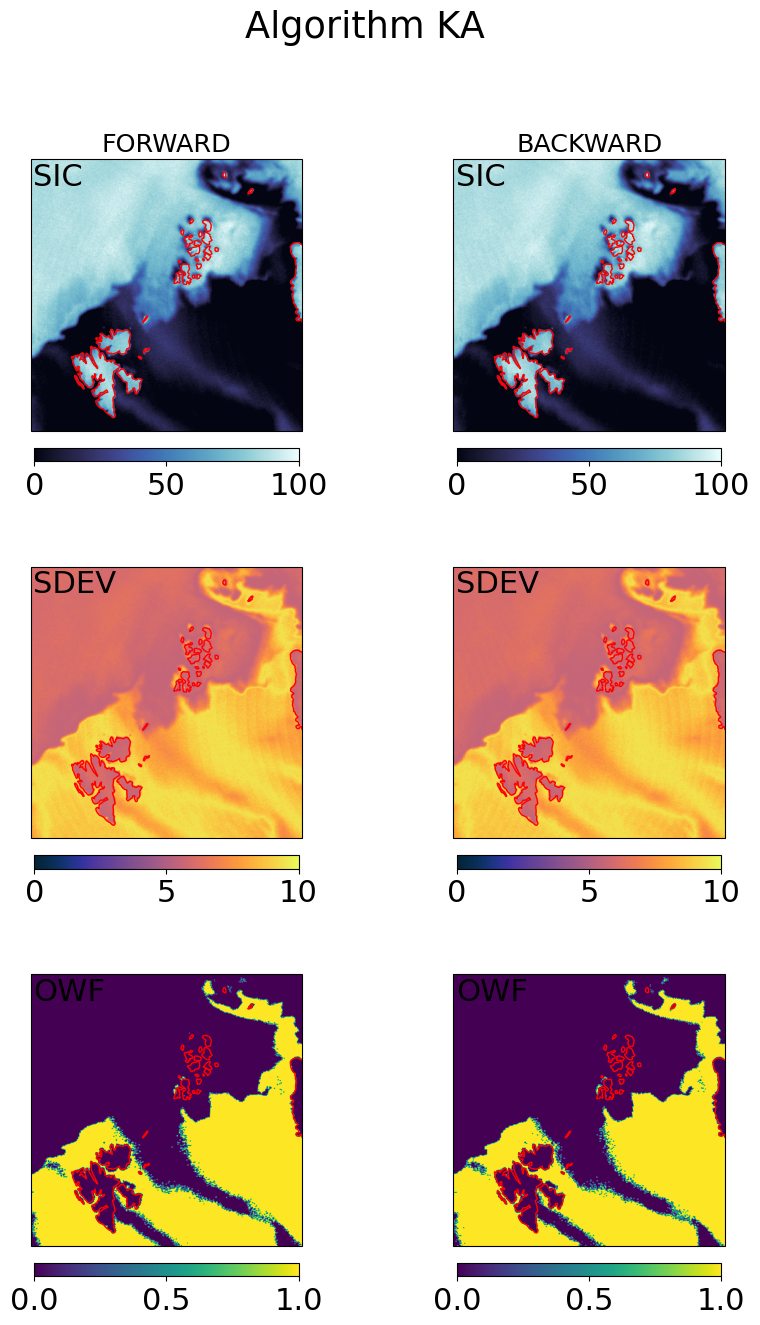

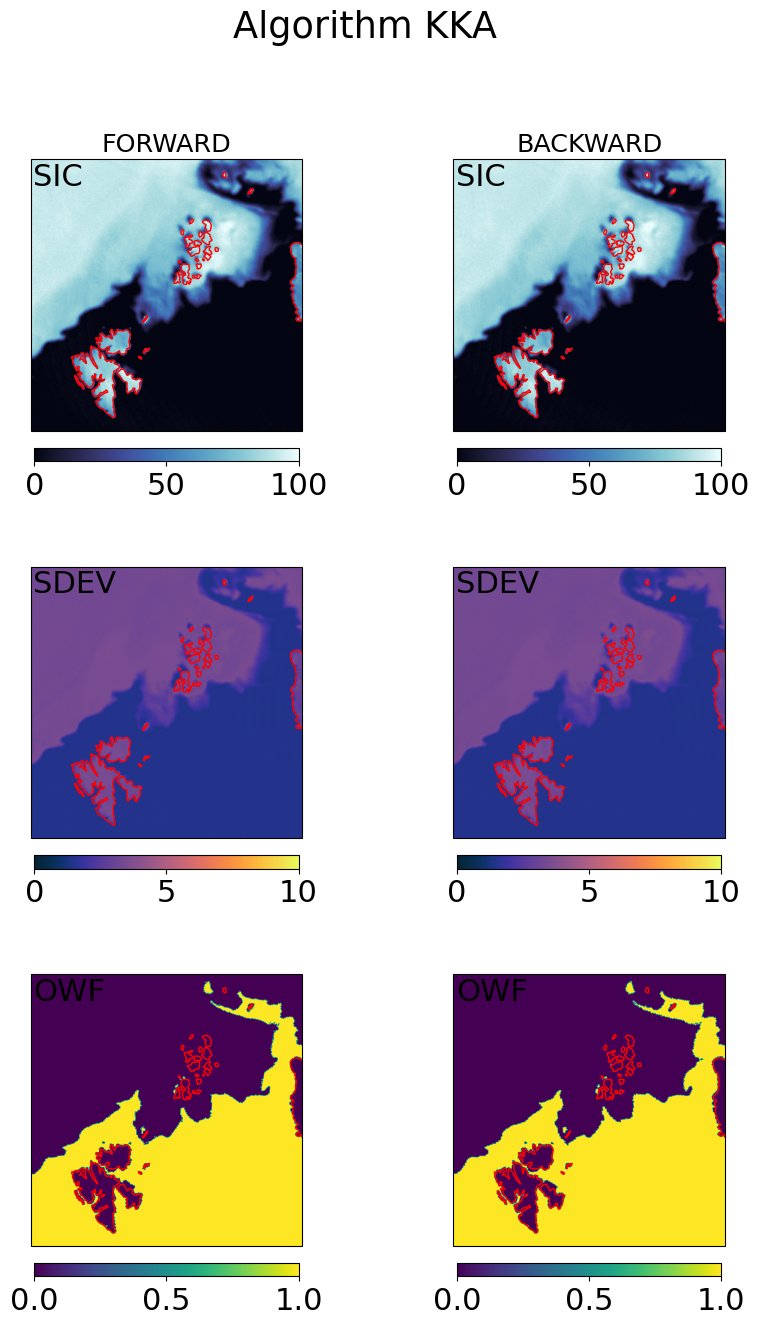

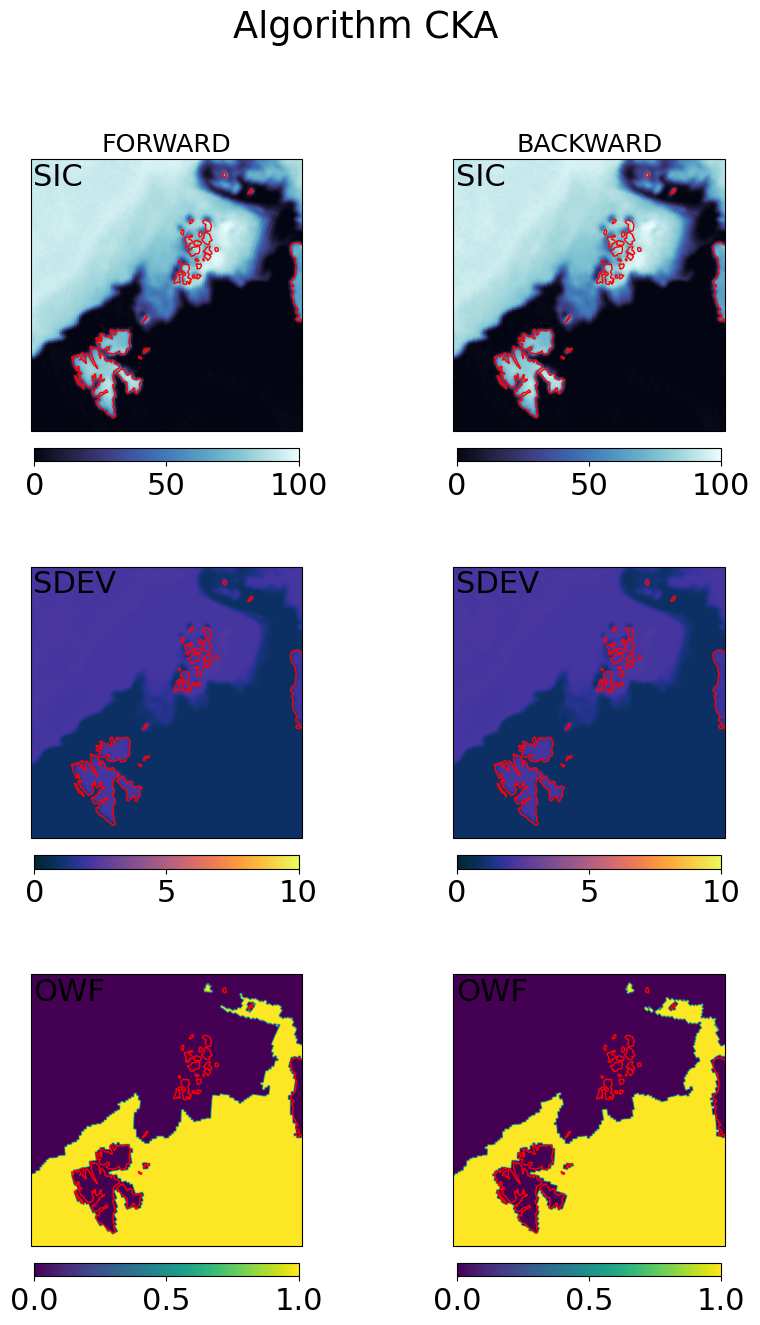

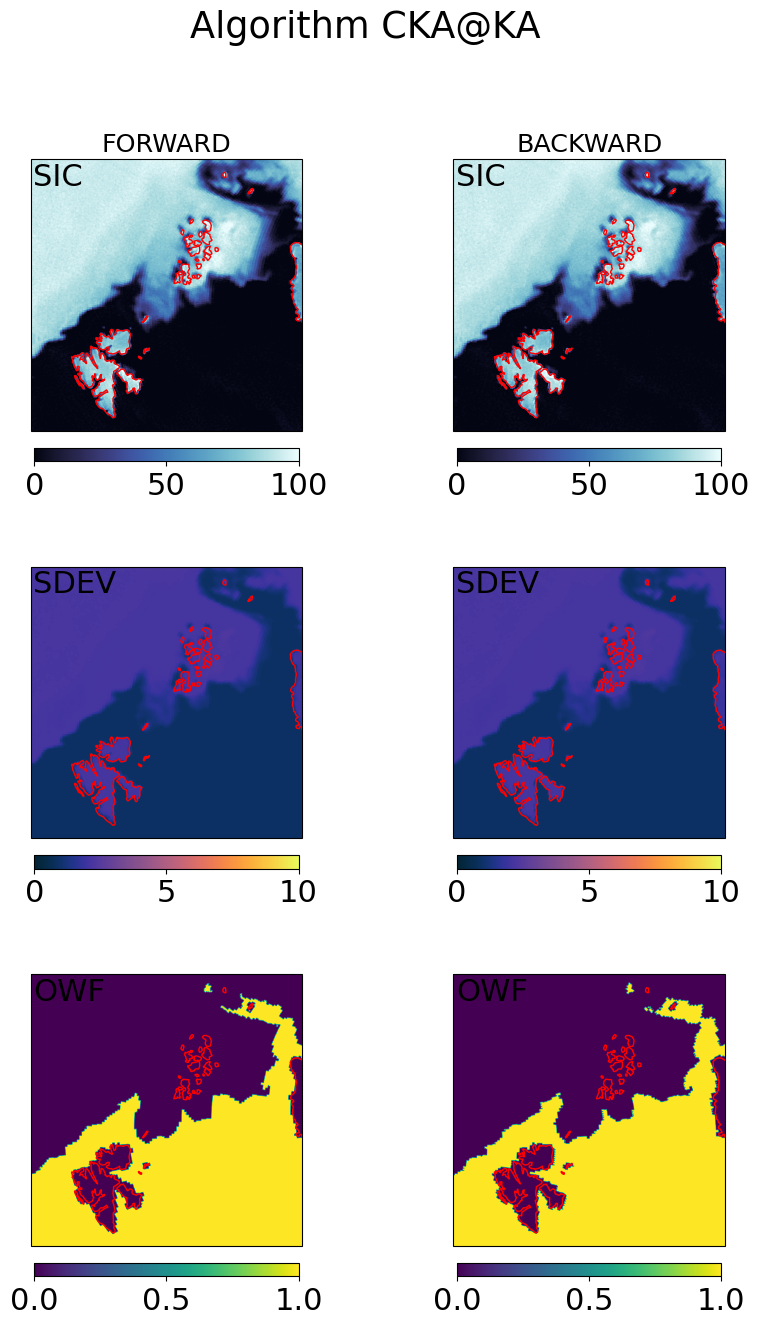

In [20]:
# visualization of the gridded fields
cmap = cmocean.cm.ice
ucmap = cmocean.cm.thermal
ocmap = plt.colormaps.get_cmap('viridis')
vmin, vmax = (0, 100)
umin, umax = (0, 10)
omin, omax = (0, 1)

cart_crs = adef.to_cartopy_crs()

for galg in galgs:

    fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(10,15),
                       subplot_kw=dict(projection=cart_crs))
    
    fig.suptitle("Algorithm {}".format(galg))
    
    # first row : SICs
    c = ax[0,0].imshow(100*fwd_grd[galg].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
    ax[0,0].coastlines(color='red')
    ax[0,0].set_title('FORWARD', fontsize='small')
    ax[0,0].text(0.01,0.99,'SIC',va='top',transform=ax[0,0].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)

    c = ax[0,1].imshow(100*bck_grd[galg].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
    ax[0,1].coastlines(color='red')
    ax[0,1].set_title('BACKWARD', fontsize='small')
    ax[0,1].text(0.01,0.99,'SIC',va='top',transform=ax[0,1].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)

    # second row : SDEVs
    c = ax[1,0].imshow(fwd_grd[galg].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
    ax[1,0].coastlines(color='red')
    ax[1,0].text(0.01,0.99,'SDEV',va='top',transform=ax[1,0].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)
    c=ax[1,1].imshow(bck_grd[galg].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
    ax[1,1].coastlines(color='red')
    ax[1,1].text(0.01,0.99,'SDEV',va='top',transform=ax[1,1].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)

    # second row : OWF
    c = ax[2,0].imshow(fwd_grd[galg].owf, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ocmap,vmin=omin,vmax=omax)
    ax[2,0].coastlines(color='red')
    ax[2,0].text(0.01,0.99,'OWF',va='top',transform=ax[2,0].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)
    c=ax[2,1].imshow(bck_grd[galg].owf, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ocmap,vmin=omin,vmax=omax)
    ax[2,1].coastlines(color='red')
    ax[2,1].text(0.01,0.99,'OWF',va='top',transform=ax[2,1].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.75)

    plt.show()

In [21]:
# we call the result, the "merged" sic:
mrg_grd = dict()
mrg_grd_raw = dict()
mrg_grd_flags = dict()
mrg_grd_flag_comment = "0: no_data, 1: fwd_only, 2: bck_only, 3: fwd_and_bck"

for galg in galgs:

    # have a flag to indicate where the forward and backward scans contributed
    mrg_grd_flag = np.zeros(fwd_grd[galg].sic.shape, dtype='i8')
    _fwd_valid = ~(fwd_grd[galg].sic.mask)
    _bck_valid = ~(bck_grd[galg].sic.mask)
    mrg_grd_flag[_fwd_valid *  _bck_valid] = 3
    mrg_grd_flag[_bck_valid * ~_fwd_valid] = 2
    mrg_grd_flag[_fwd_valid * ~_bck_valid] = 1

    # we do a naive merge (arithmetic mean) for now because the uncertainties
    #   in forward and backward fields will be quite similar.
    _mrg_grd_sic = 0.5 * (fwd_grd[galg].sic + bck_grd[galg].sic)
    _mrg_grd_sic[_fwd_valid * ~_bck_valid] = fwd_grd[galg].sic[_fwd_valid * ~_bck_valid]
    _mrg_grd_sic[_bck_valid * ~_fwd_valid] = bck_grd[galg].sic[_bck_valid * ~_fwd_valid]

    # the uncertainties in the forward and backward SIC fields are highly correlated,
    #   thus at the first order the uncertainties are the mean uncertainty (in variance).
    #   This should be revisited e.g. to reduce the uncertainty due to NeDT (which is small
    #   wrt that due to tie-points).
    _mrg_grd_var = 0.5 * (fwd_grd[galg].sdev**2 + bck_grd[galg].sdev**2)
    _mrg_grd_var[_fwd_valid * ~_bck_valid] = fwd_grd[galg].sdev[_fwd_valid * ~_bck_valid]**2
    _mrg_grd_var[_bck_valid * ~_fwd_valid] = bck_grd[galg].sdev[_bck_valid * ~_fwd_valid]**2
    _mrg_grd_sdev = _mrg_grd_var**0.5

    # Combine the OWF with a OR() operator : if one view detected a target as open-water, trust that.
    _mrg_grd_owf = np.zeros(fwd_grd[galg].sic.shape, dtype='i4')
    _mrg_grd_owf = np.ma.where( (fwd_grd[galg].owf + bck_grd[galg].owf) >= 1, 1, 0)
    _mrg_grd_owf[_fwd_valid * ~_bck_valid] = fwd_grd[algo].owf[_fwd_valid * ~_bck_valid]
    _mrg_grd_owf[_bck_valid * ~_fwd_valid] = bck_grd[algo].owf[_bck_valid * ~_fwd_valid]
    

    # Filter the SIC with the (gridded OWF), and apply the thresholds. 
    print("FILTER AND THRESHOLD THE 'raw' {} SIC:".format(galg))

    _mrg_grd_fsic = _mrg_grd_sic.copy()
    _mrg_grd_fsic[_mrg_grd_owf > 0] = 0.
    _mrg_grd_fsic[_mrg_grd_fsic < 0] = 0.
    _mrg_grd_fsic[_mrg_grd_fsic > 1] = 1.

    print("Range of 'raw' SIC (before filtering and thesholding): [{:.2f}:{:.2f}]".format(
        _mrg_grd_sic.min(), _mrg_grd_sic.max()))
    print("Range of 'filtered' SIC (after filtering and thesholding): [{:.2f}:{:.2f}]".format(
        _mrg_grd_fsic.min(), _mrg_grd_fsic.max()))

    # store in an object (we store the filtered SIC, but keep the raw SIC as well)
    mrg_grd[galg] = sic_algo.SICAlgoResult(_mrg_grd_fsic, _mrg_grd_sdev, _grd_zeros, _mrg_grd_owf)
    mrg_grd_flags[galg] = mrg_grd_flag
    mrg_grd_raw[galg] = _mrg_grd_sic

FILTER AND THRESHOLD THE 'raw' KA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.25:1.00]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:1.00]
FILTER AND THRESHOLD THE 'raw' KKA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.07:1.01]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:1.00]
FILTER AND THRESHOLD THE 'raw' CKA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.03:1.00]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:1.00]


FILTER AND THRESHOLD THE 'raw' CKA@KA SIC:
Range of 'raw' SIC (before filtering and thesholding): [-0.23:1.13]
Range of 'filtered' SIC (after filtering and thesholding): [0.00:1.00]


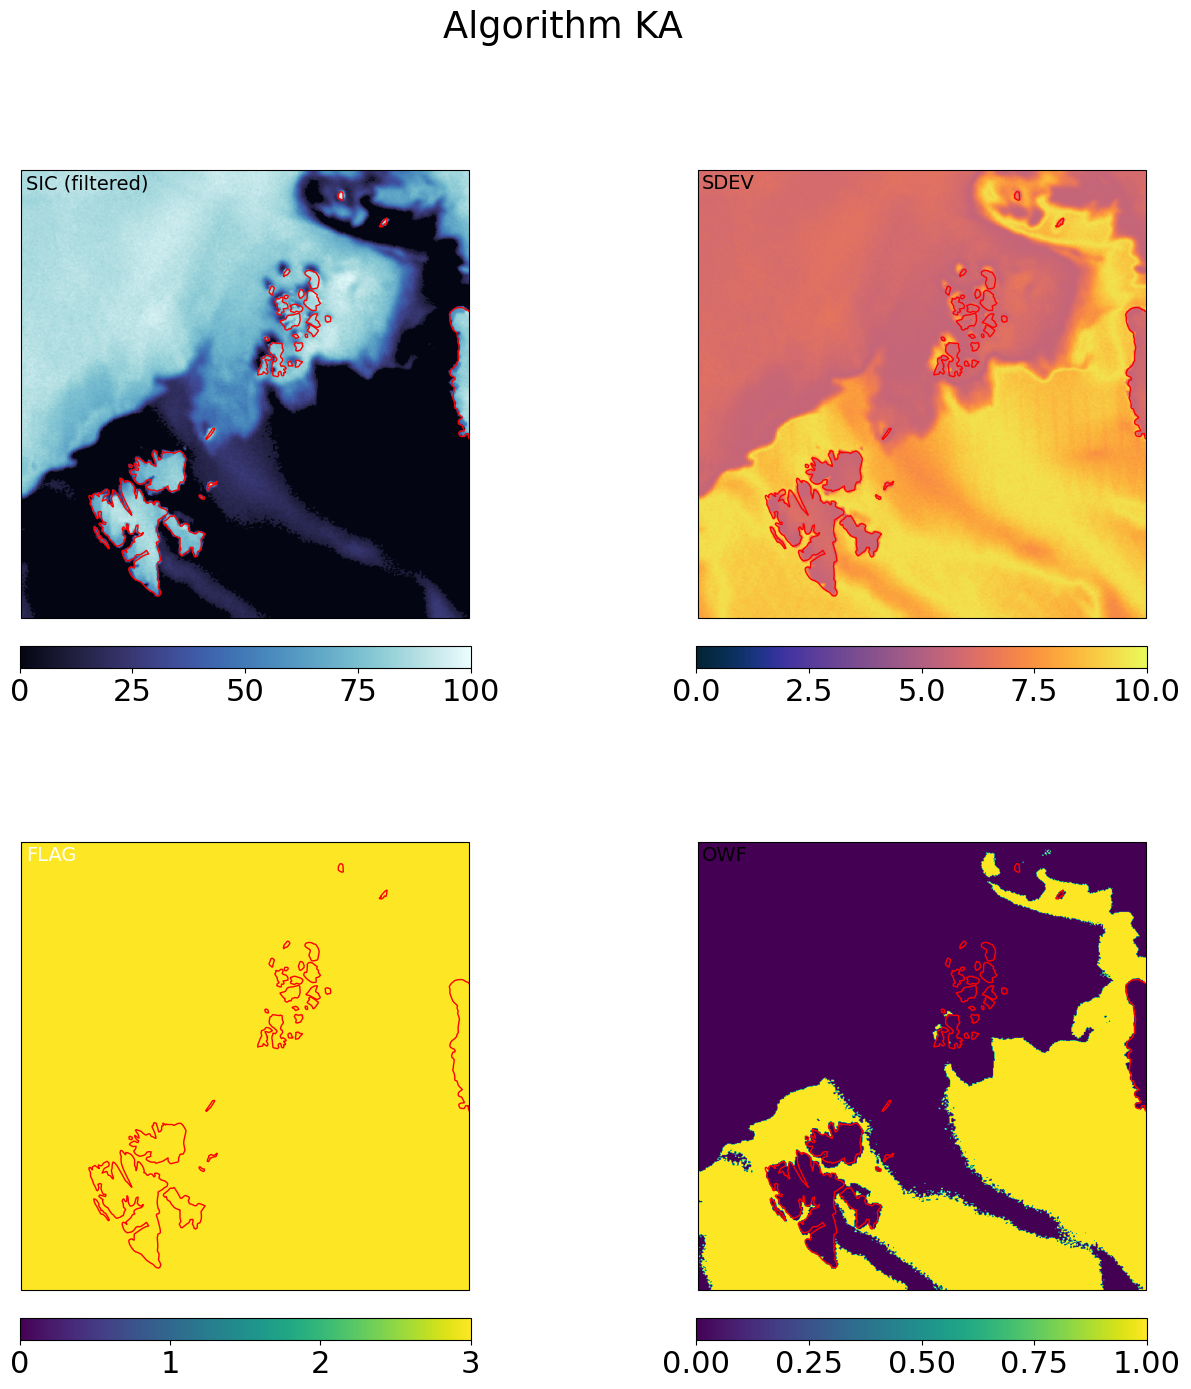

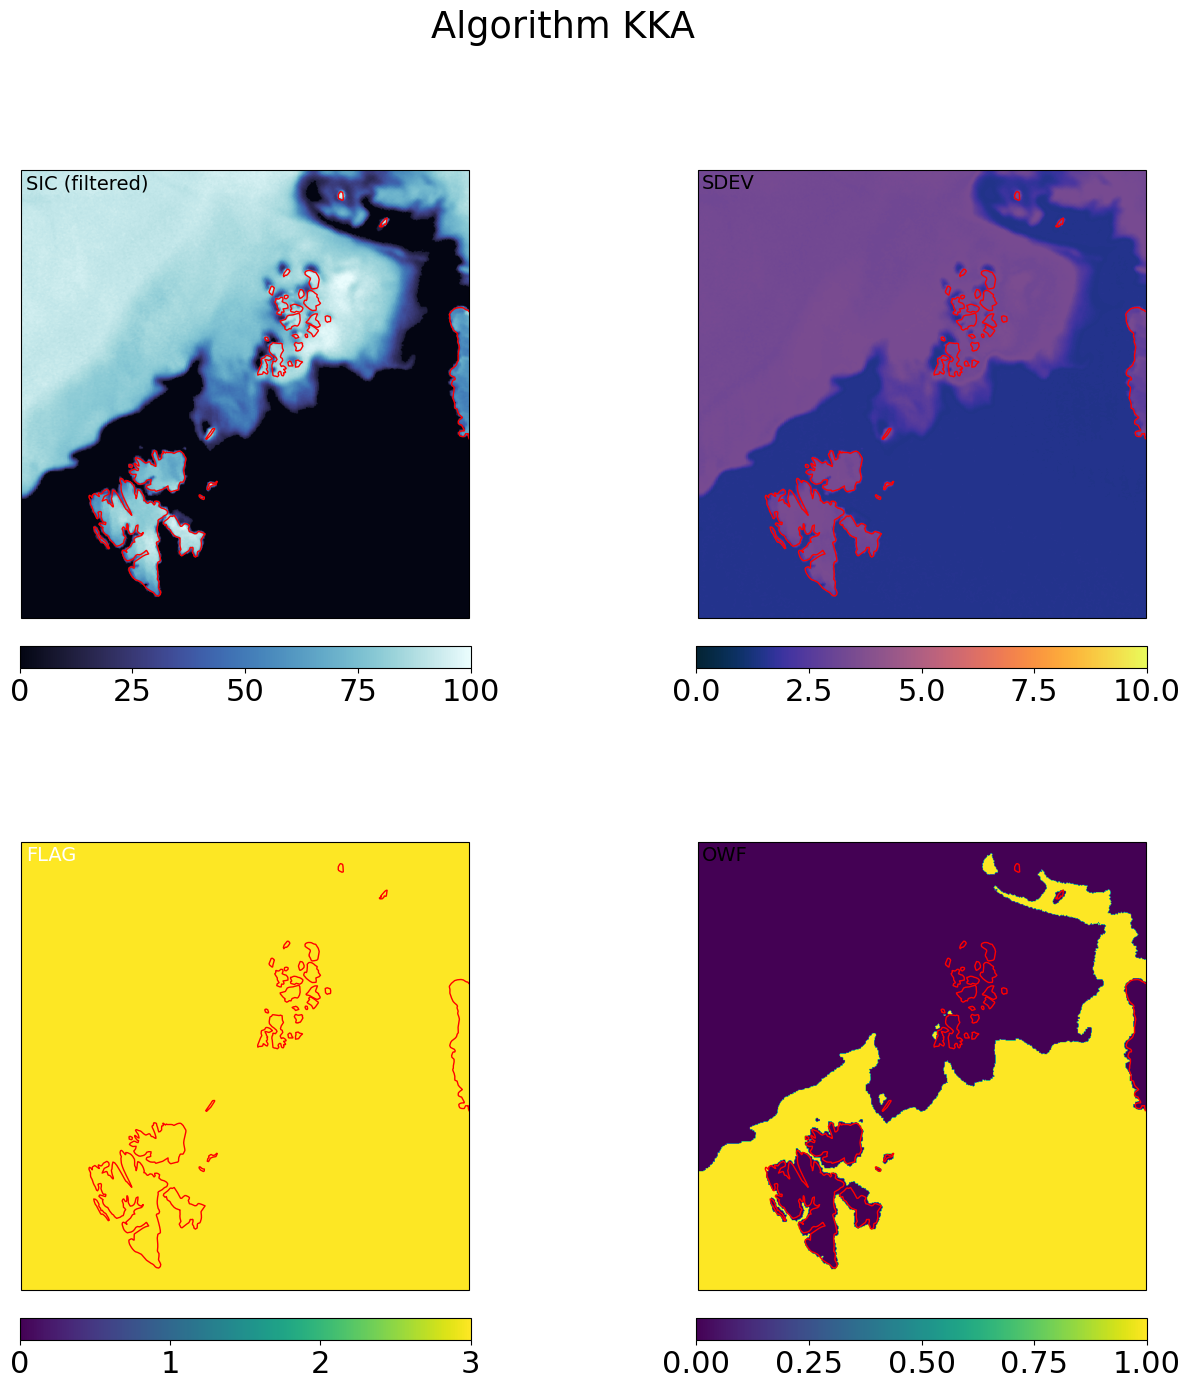

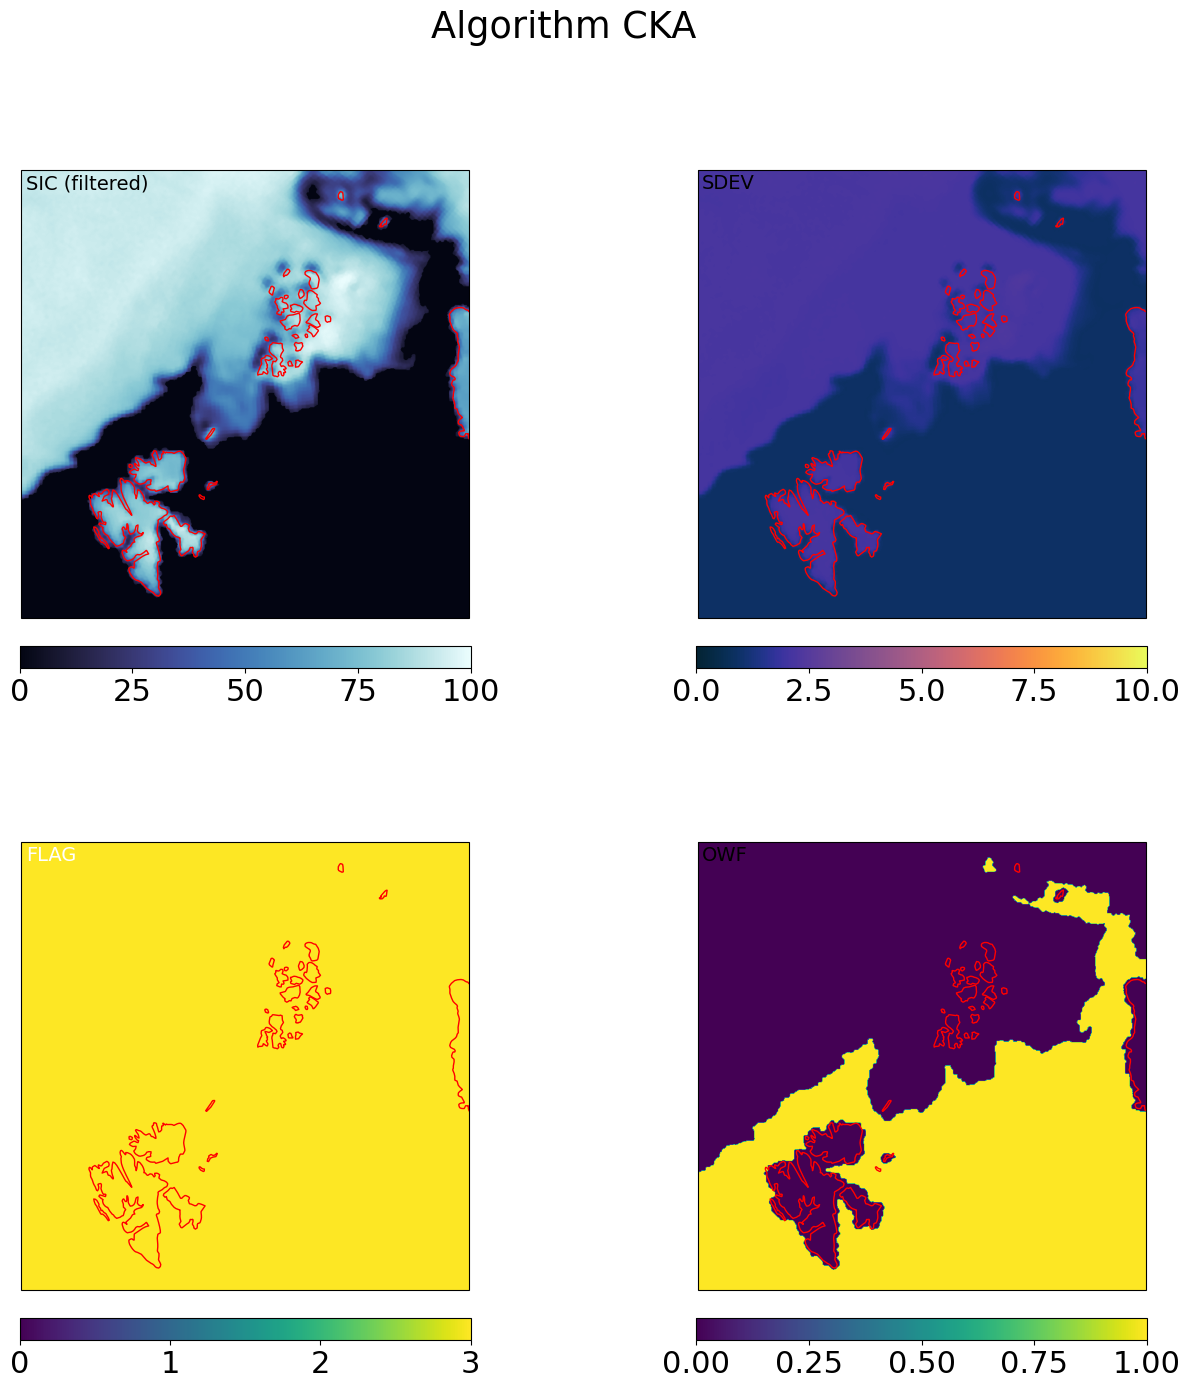

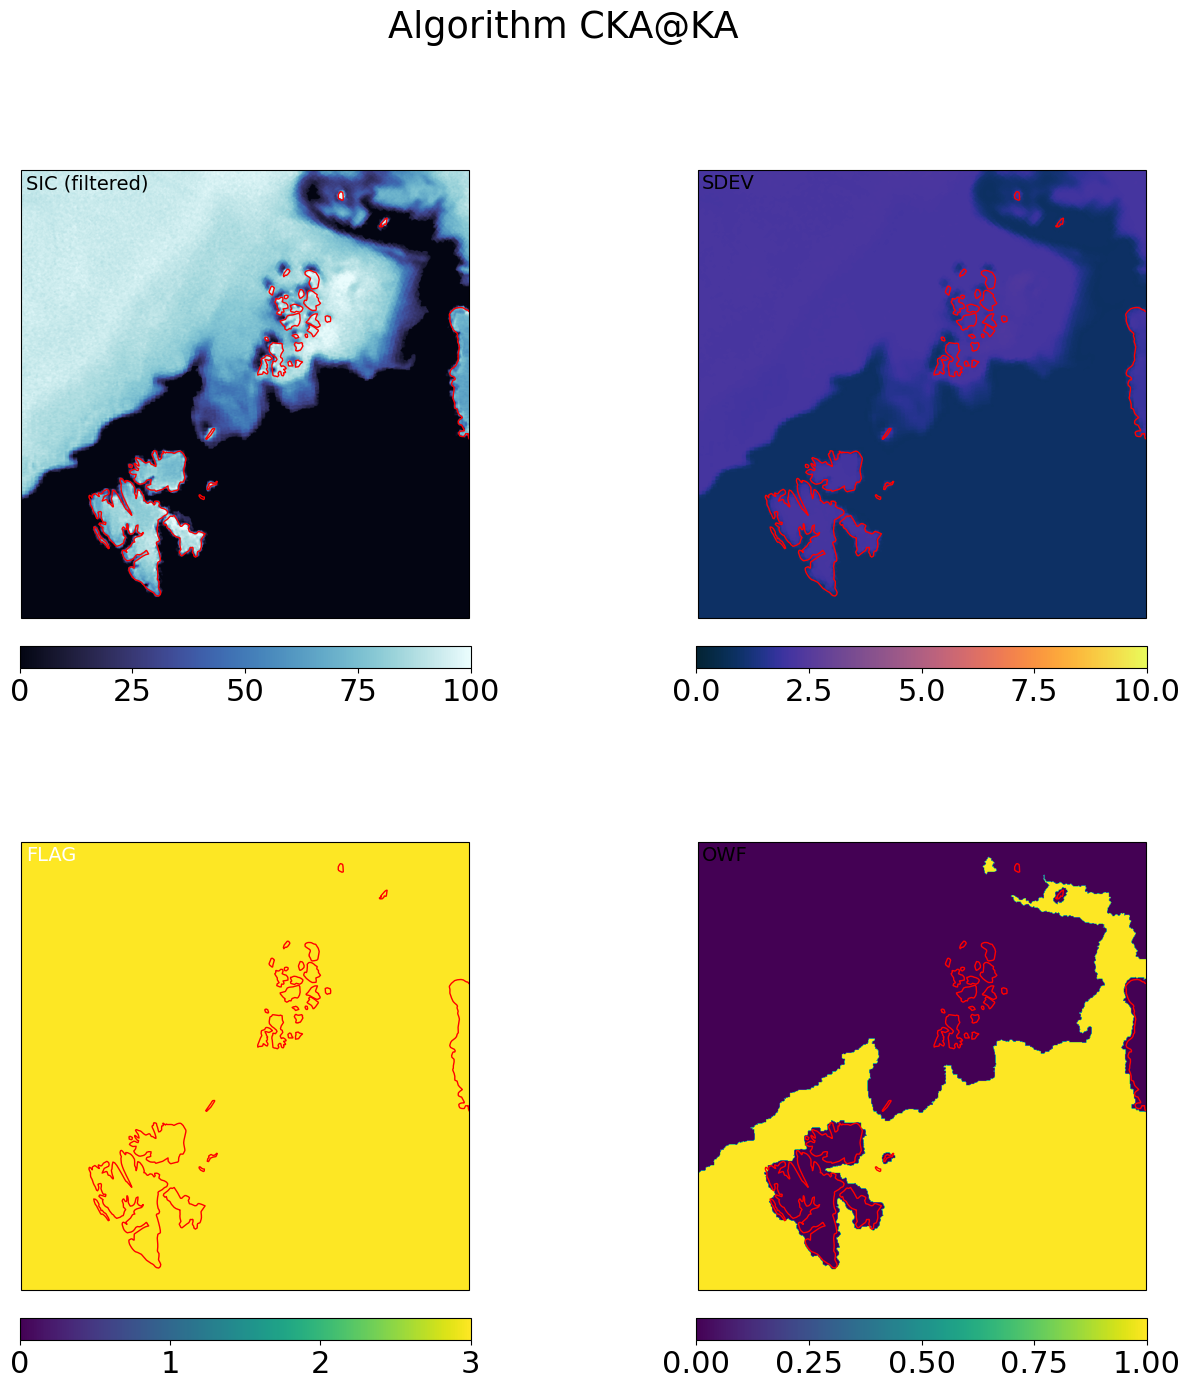

In [22]:
# visualize / plot

for galg in galgs:

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16,16), subplot_kw=dict(projection=cart_crs))
    fig.suptitle("Algorithm {}".format(galg))
    
    # first : SICs
    c = ax[0,0].imshow(100*mrg_grd[galg].sic, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=vmin,vmax=vmax)
    ax[0,0].coastlines(color='red')
    ax[0,0].text(0.01,0.99,'SIC (filtered)',va='top',fontsize=14,transform=ax[0,0].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)

    # second : SDEVs
    c = ax[0,1].imshow(mrg_grd[galg].sdev, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=ucmap,vmin=umin,vmax=umax)
    ax[0,1].coastlines(color='red')
    ax[0,1].text(0.01,0.99,'SDEV',va='top',fontsize=14,transform=ax[0,1].transAxes)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)

    # third : FLAG
    c = ax[1,0].imshow(mrg_grd_flags[galg], transform=cart_crs, extent=cart_crs.bounds, origin='upper',vmin=0,vmax=3)
    ax[1,0].coastlines(color='red')
    ax[1,0].text(0.01,0.99,'FLAG',va='top',fontsize=14,transform=ax[1,0].transAxes,color='w')
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8,)

    # fourth : OWF
    c = ax[1,1].imshow(mrg_grd[galg].owf, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
                   cmap=ocmap, vmin=omin, vmax=omax)
    ax[1,1].coastlines(color='red')
    ax[1,1].text(0.01,0.99,'OWF',va='top',fontsize=14,transform=ax[1,1].transAxes,)
    plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8,)

    plt.show()

In [23]:
sied_mrg_grd = np.ma.where(mrg_grd['CKA@KA'].sic >= 0.15, 1, 0).astype('int16')

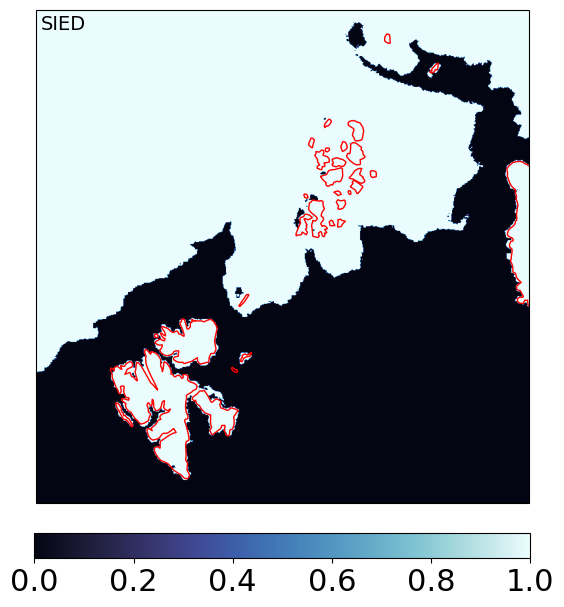

In [24]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=cart_crs))
c = ax.imshow(sied_mrg_grd, transform=cart_crs, extent=cart_crs.bounds, origin='upper',
              cmap=cmap,vmin=0, vmax=1)
ax.coastlines(color='red')
ax.text(0.01,0.99,'SIED',va='top',fontsize=14,transform=ax.transAxes)
plt.colorbar(c,orientation='horizontal', pad=0.05, shrink=0.8)
plt.show()

In [25]:
# Compute a Timestamp for the L2 product file

# associate a time to this L2 product.
min_l1b_dt = full_l1b.data['C']['time_earth'].data.min()
max_l1b_dt = full_l1b.data['C']['time_earth'].data.max()

# some simulated files have a wrong units of "days", then we get 'time_earth' as timedelta64.
#   fix for these
if full_l1b.data['C']['time_earth'].encoding['units'] == 'days':
    print("Correct L1B time (wrong unit in L1B file)")
    min_l1b_dt += np.datetime64('2000-01-01')
    max_l1b_dt += np.datetime64('2000-01-01')

# arbitrarily, associate middle time of l1b to l2
l2_dt = min_l1b_dt + (max_l1b_dt - min_l1b_dt) * 0.5

In [26]:
def write_L2_SIC_file(mrg_grd, mrg_grd_raw, sied_mrg_grd, algo, adef, l2_n, l2_dt, min_l1b_dt, max_l1b_dt):
    
    # change SIC from [0-1] to [0-100%] range for writing to file (the SDEV is already in %)
    fSIC = mrg_grd[algo].sic * 100
    rSIC = mrg_grd_raw[algo] * 100

    if sied_mrg_grd is not None:
        SIED = sied_mrg_grd.copy().filled(-1)
    else:
        SIED = None
    
    # get a template L2 format (netCDF/CF) from the Tools module
    ds_l2 = l2.get_CIMR_L2_template('grid', geo_def=adef, add_time=[l2_dt, min_l1b_dt, max_l1b_dt])

    # create a DataArray for the filtered SIC from the template
    da_sic = xr.DataArray(fSIC[None,:,:], coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='ice_conc')
    da_sic.attrs['long_name'] = 'Sea Ice Concentration from the {} algorithm, after open-water filtering (OWF) and thresholding were applied.'.format(algo)
    da_sic.attrs['standard_name'] = 'sea_ice_area_fraction'
    da_sic.attrs['units'] = 1
    da_sic.attrs['coverage_content_type'] = 'physicalMeasurement'
    da_sic.attrs['auxiliary_variables'] = 'ice_conc_total_uncertainty,status_flag'
    da_sic.encoding = {'_FillValue': -999.}

    # create a DataArray for SDEV from the template
    da_sdev = xr.DataArray(mrg_grd[algo].sdev[None,:,:], coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='ice_conc_total_uncertainty')
    da_sdev.attrs['long_name'] = 'Total Uncertainty for the Sea Ice Concentration from the {} algorithm'.format(algo)
    da_sdev.attrs['standard_name'] = 'sea_ice_area_fraction standard_error'
    da_sdev.attrs['coverage_content_type'] = 'qualityInformation'
    da_sdev.attrs['units'] = 1
    da_sdev.encoding = {'_FillValue': -999.}

    # create a DataArray for FLAG from the template
    da_flg = xr.DataArray(mrg_grd_flag[None,:,:], coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='status_flag')
    da_flg.attrs['long_name'] = 'Processing and status flags for the Sea Ice Concentraion from the {} algorithm'.format(algo)
    da_flg.attrs['coverage_content_type'] = 'auxiliaryInformation'
    da_flg.attrs['comment'] = mrg_grd_flag_comment
    da_flg.encoding = {'_FillValue': None}

    # create a DataArray for the Open Water Filter (OWF) from the template
    da_owf = xr.DataArray(mrg_grd[algo].owf[None,:,:], coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='open_water_filter')
    da_owf.attrs['long_name'] = 'Open Water Filter flag'
    da_owf.attrs['units'] = 1
    da_owf.attrs['coverage_content_type'] = 'physicalMeasurement'
    da_owf.attrs['auxiliary_variables'] = 'status_flag'
    da_owf.encoding = {'_FillValue': -1}

    # create a DataArray for raw SIC values from the template
    da_rsic = xr.DataArray(rSIC[None,:,:], coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='raw_ice_conc_values')
    da_rsic.attrs['long_name'] = 'Raw sea-ice Concentration from the {} algorithm, without OWF nor thresholding'.format(algo)
    da_rsic.attrs['units'] = 1
    da_rsic.attrs['coverage_content_type'] = 'physicalMeasurement'
    da_rsic.attrs['auxiliary_variables'] = 'status_flag'
    da_rsic.encoding = {'_FillValue': -999.}

    if SIED is not None:
        # create a DataArray for Sea Ice Edge values from the template
        da_sied = xr.DataArray(SIED[None,:,:], coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='ice_edge').astype(sied_mrg_grd.dtype)
        da_sied.attrs['standard_name'] = 'sea_ice_classification'
        da_sied.attrs['long_name'] = 'Sea-ice edge classification product'
        da_sied.attrs['flag_values'] = np.array([0, 1], dtype=sied_mrg_grd.dtype)
        da_sied.attrs['flag_meanings'] = "open_water sea_ice"
        da_sied.attrs['coverage_content_type'] = 'physicalMeasurement'
        da_sied.attrs['auxiliary_variables'] = 'status_flag'
        da_sied.encoding = {'_FillValue': np.int16(-1)}

    # add the data arrays to the ds_l2 object
    ds_l2 = ds_l2.merge(da_sic)
    ds_l2 = ds_l2.merge(da_sdev)
    ds_l2 = ds_l2.merge(da_flg)
    ds_l2 = ds_l2.merge(da_owf)
    ds_l2 = ds_l2.merge(da_rsic)
    if SIED is not None:
        ds_l2 = ds_l2.merge(da_sied)

    # customize the global attributes
    ds_l2.attrs['title'] = 'CIMR L2 NRT3H Sea Ice Concentration and Edge'
    ds_l2.attrs['summary'] = 'Sea Ice Concentration and Edge, computed with the prototype algorithm developped in the ESA CIMR DEVALGO study. The algorithm combines C and Ka imagery channels. The product file contains both the SIC, its uncertainties, and processing flags.'
    ds_l2.attrs['l1b_file'] = os.path.basename(l1b_path)
    ds_l2.attrs['algorithm_version'] = algo_version
    ds_l2.attrs['algorithm_name'] = algo
    ds_l2.attrs['algorithm_tuning'] = tuning_method
    ds_l2.attrs['use_oza_adjusted_tbs'] = {True:'Yes', False:'No'}[use_oza_adjust]

    ds_l2.attrs['creator_name'] = 'Thomas Lavergne'
    ds_l2.attrs['creator_email'] = 'thomas.lavergne@met.no'
    ds_l2.attrs['institution'] = 'Norwegian Meteorological Institute'

    # remove the 'template' variable (we don't need it anymore)
    ds_l2 = ds_l2.drop_vars(['template',])

    # final configuration of the netCDF file using encoding
    encoding = {'lat': {'_FillValue': None},
            'lon': {'_FillValue': None},
            'time_bnds': {'_FillValue': None},}

    # write to file

    ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)

In [27]:
# Main CKA@KA algorithm
l2_n = 'cimr_devalgo_l2_sic_{}_{}.nc'.format(l2_grid, test_card_name.replace('_','-'), )
l2_n = os.path.join(l2_dir, l2_n)
write_L2_SIC_file(mrg_grd, mrg_grd_raw, sied_mrg_grd, 'CKA@KA', adef, l2_n, l2_dt, min_l1b_dt, max_l1b_dt)
print(l2_n)

# The other algorithms (we don't write a SIED product)
for alg in ('CKA', 'KKA', 'KA'):
    l2_n = 'cimr_devalgo_l2_sic-{}_{}_{}.nc'.format(alg, l2_grid, test_card_name.replace('_','-'), )
    l2_n = os.path.join(l2_dir, l2_n)
    write_L2_SIC_file(mrg_grd, mrg_grd_raw, None, alg, adef, l2_n, l2_dt, min_l1b_dt, max_l1b_dt)
    print(l2_n)

/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)
/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)


../data/output/cimr_devalgo_l2_sic_ease2-1.0km-testcard_sceps-polar1.nc


/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)
/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)


../data/output/cimr_devalgo_l2_sic-CKA_ease2-1.0km-testcard_sceps-polar1.nc


/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)
/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)


../data/output/cimr_devalgo_l2_sic-KKA_ease2-1.0km-testcard_sceps-polar1.nc


../data/output/cimr_devalgo_l2_sic-KA_ease2-1.0km-testcard_sceps-polar1.nc


/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)
/tmp/ipykernel_390016/1740271362.py:104: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2000-01-01T00:00:00+00:00'. Resolution of 'nanoseconds' needed. Serializing times to floating point instead. Set encoding['dtype'] to integer dtype to serialize to int64. Set encoding['dtype'] to floating point dtype to silence this warning.
  ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC', encoding=encoding)
